In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models
# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan}, #uneuseful for paris
                 'ricseq': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False,
                  'MIN_N_READS_RICSEQ' : 3},
                 'splash': 
                 {'only_test' : True,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan},  #uneuseful for splash
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan},  #uneuseful for mario
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079') 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

DATASET: paris
easypos_smartneg


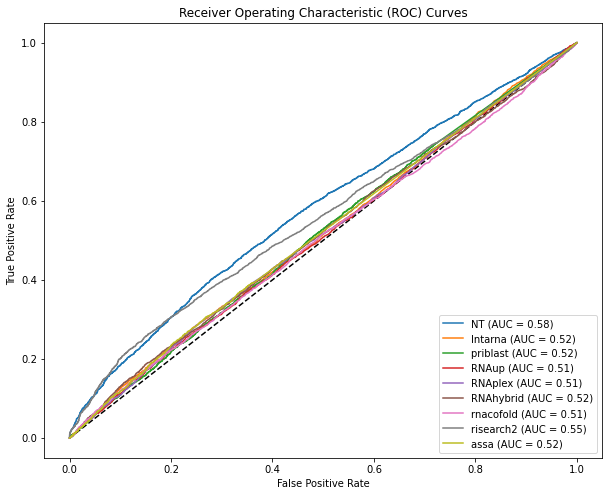

ephnen


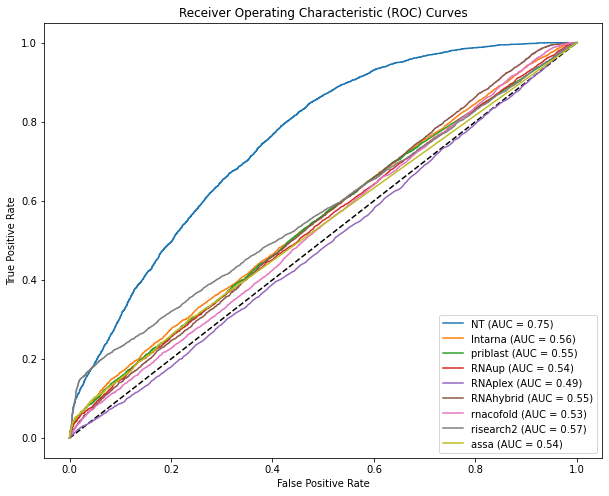

enhn500


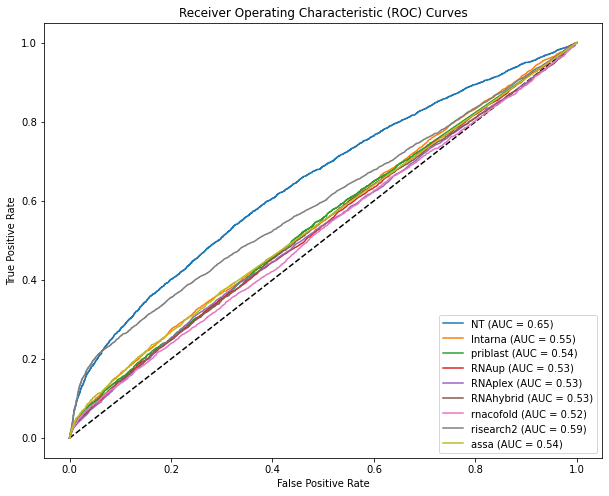




# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
DATASET: ricseq
easypos_smartneg


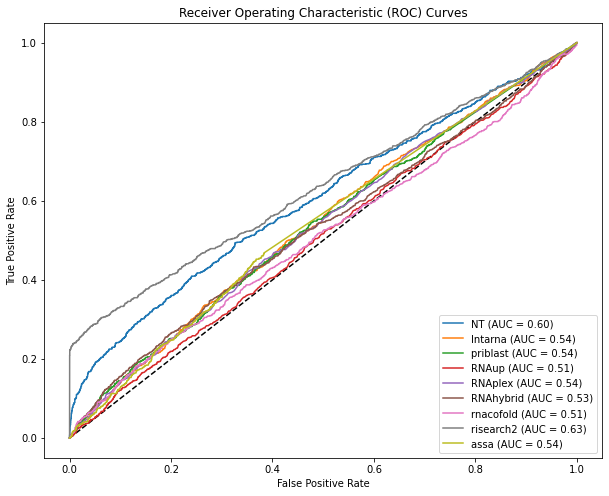

ephnen


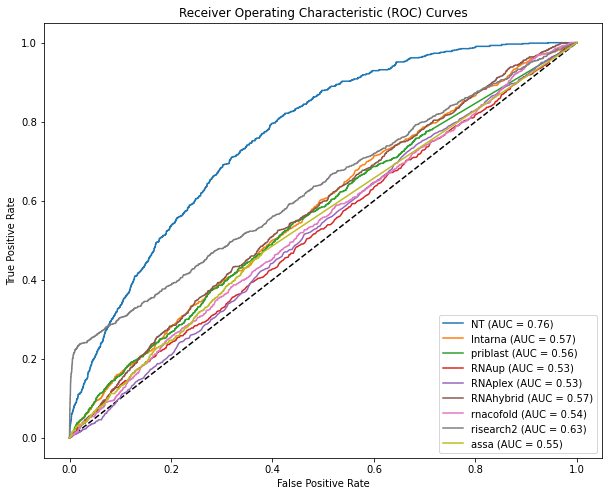

enhn500


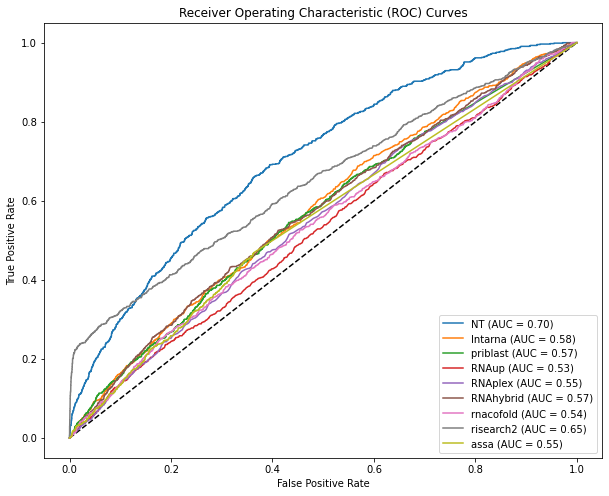




# excluded couples:  12
# excluded couples:  12
# excluded couples:  12
DATASET: splash
easypos_smartneg


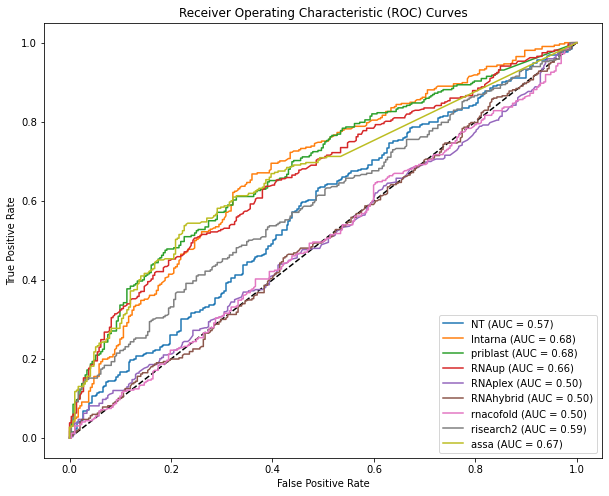

ephnen


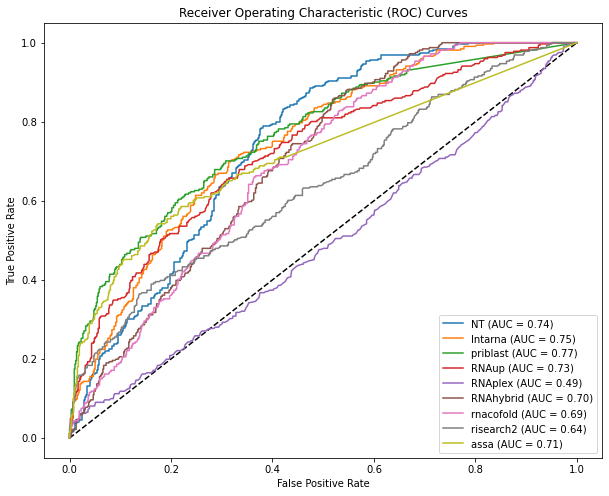

enhn500


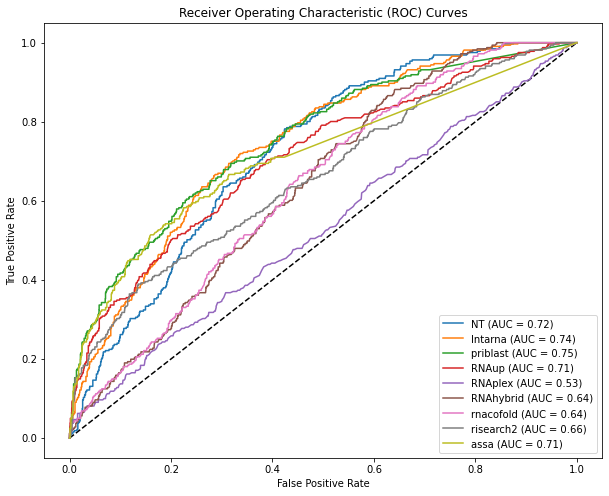




# excluded couples:  4
# excluded couples:  4
# excluded couples:  4
DATASET: mario
easypos_smartneg


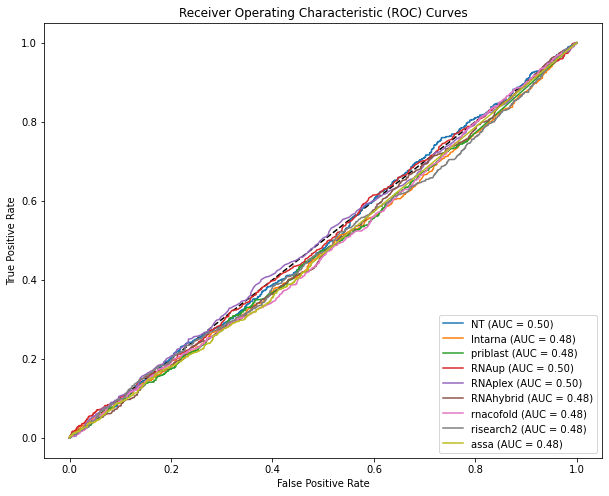

ephnen


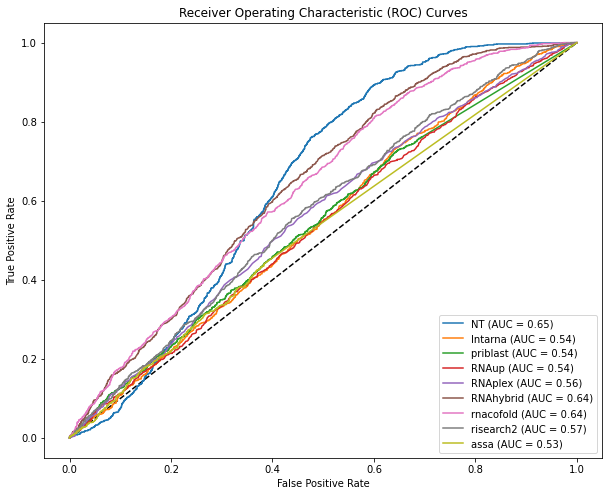

enhn500


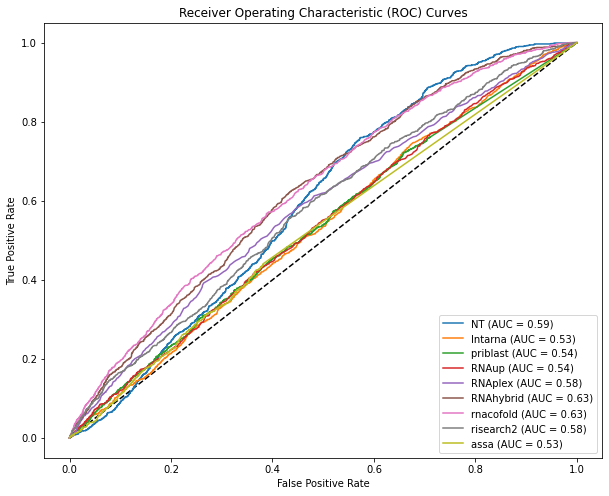

In [5]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS, True)   
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS, False)
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    res = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    enhn500 = balance_df(res).reset_index(drop = True)
    
    
    print(f'DATASET: {dataset}')
    print('easypos_smartneg')
    plot_all_model_auc(easypos_smartneg, tools)
    print('ephnen')
    plot_all_model_auc(ephnen, tools)
    print('enhn500')
    plot_all_model_auc(enhn500, tools)
    print('\n\n')
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

ricseq


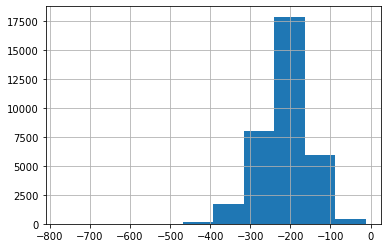

In [6]:
tool_name = 'RNAhybrid' #RNAhybrid
for how in ['ricseq']: #['ricseq', 'mario', 'test', 'splash']
    tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
    tool['value'] = tool['value'].astype(float)
    print(how)
    tool.value.hist()
    plt.show()
    print('\n')

# Map models signal in [0, 1] and save the mapping

##### Train the model (we train with paris)

In [11]:
threshold_remove_outliers = 2


dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         False, 
                         False, 
                         False, 
                         False,
                         False, 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS)
    
    df_training = res.copy()
    n_hardneg_easyneg_to_sample = df_training[df_training.policy == 'smartneg'].shape[0]
    easyneg_hardneg_training = df_training[df_training.policy.isin(['hardneg', 'easyneg'])]
    easyneg_hardneg_training = easyneg_hardneg_training.sample(n_hardneg_easyneg_to_sample)
    df_training = pd.concat([
        df_training[df_training.policy.isin(['smartneg', 'easypos'])],
        easyneg_hardneg_training
    ], axis = 0).reset_index(drop = True)
    dfs.append(df_training)

In [12]:
df_training = pd.concat(dfs, axis = 0).reset_index(drop = True)

In [13]:
logistic_regression_models = {}
for model_column in tqdm(energy_columns):
    
    
    df_s = df_training.copy()
    df_s = remove_outliers(df_s, model_column)
    df_s = balance_df(df_s)
    
    X_train, y_train = np.expand_dims(df_s[model_column], 1), np.array(df_s.ground_truth)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Calculate threshold_value
    threshold_value = -model.intercept_ / model.coef_
    threshold_value = np.round(threshold_value[0][0], 2)

    logistic_regression_models[model_column] = {'intercept': model.intercept_[0], 
                                               'coef': model.coef_[0][0],
                                               'threshold_value': threshold_value}

  0%|          | 0/8 [00:00<?, ?it/s]

### Test and plot 

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.5392
Threshold value: -8.07


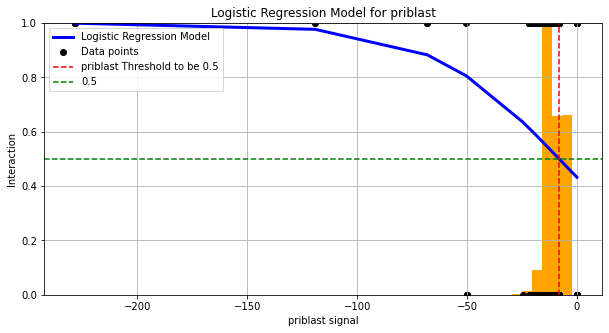

Accuracy: 0.524
Threshold value: -9.77


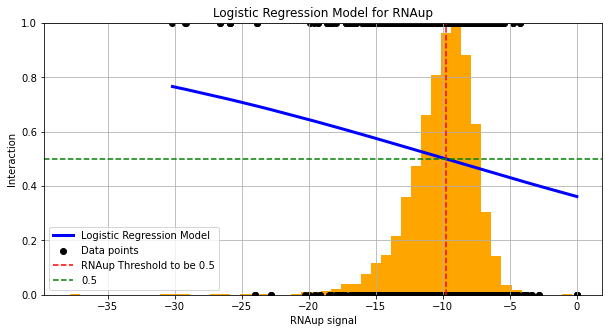

Accuracy: 0.5502
Threshold value: -33.3


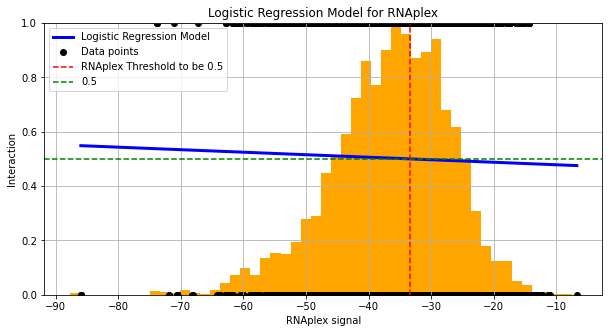

Accuracy: 0.6016
Threshold value: -213.65


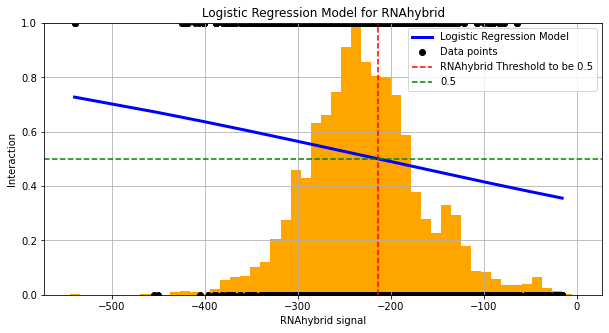

Accuracy: 0.6046
Threshold value: -318.28


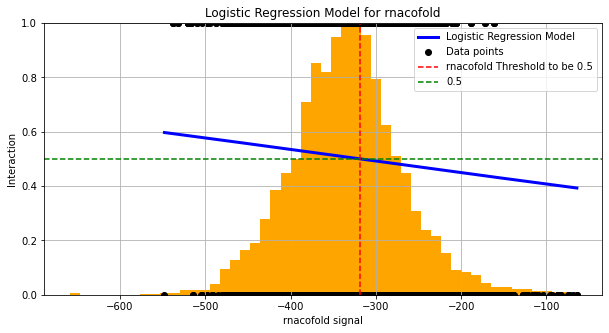

Accuracy: 0.5346
Threshold value: -41.73


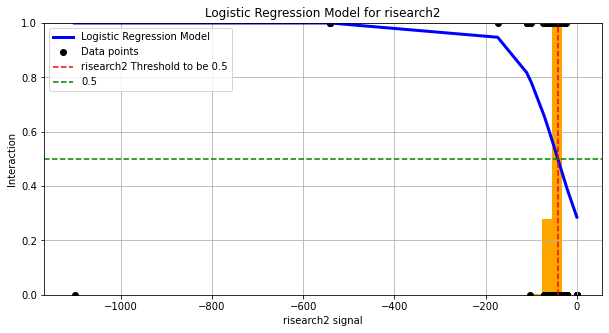

Accuracy: 0.5176
Threshold value: -6.04


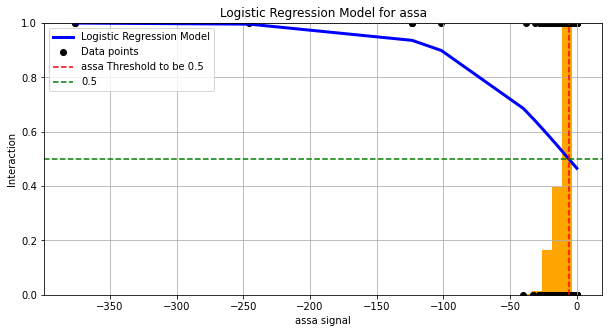

Accuracy: 0.5168
Threshold value: -1.23


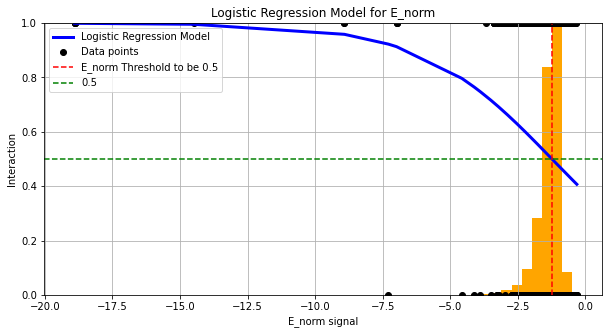

In [20]:
how = 'patches'

N_SAMPLES_TEST = 5000


plt.rcParams['figure.figsize'] = [10, 5]

for model_column in tqdm(energy_columns):
    if how == 'interactors':
        df_test = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True).copy()
    elif how == 'patches':
        df_test =res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True).copy()
      
    df_test = balance_df(df_test)
    
    sample_test = df_test.sample(N_SAMPLES_TEST)
    X_test, y_test = np.expand_dims(sample_test[model_column], 1), np.expand_dims(sample_test.ground_truth, 1)

    lrm_dict = logistic_regression_models[model_column]
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    accuracy = accuracy_score(y_test, (y_pred>0.5).astype(int))
    
    print("Accuracy:", accuracy)

    threshold_value = lrm_dict['threshold_value']
    print("Threshold value:", threshold_value)


    #Plot model and predictions
    plot_histogram_01(df_test[model_column])
    plt.plot(np.sort(X_test, axis=0), 
             log_func(lrm_dict['intercept'], lrm_dict['coef'], np.sort(X_test, axis=0))[:, 0], 
             color='blue', linewidth=3, label='Logistic Regression Model')
    plt.scatter(X_test, y_test, color='black', label='Data points')    
    plt.axvline(x=threshold_value, color='r', linestyle='--', label=f'{model_column} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')


    plt.ylim((0, 1))
    plt.xlabel(f'{model_column} signal')
    plt.ylabel('Interaction')
    plt.grid()
    plt.title(f'Logistic Regression Model for {model_column}')
    plt.legend()
    plt.show()

DATASET: paris


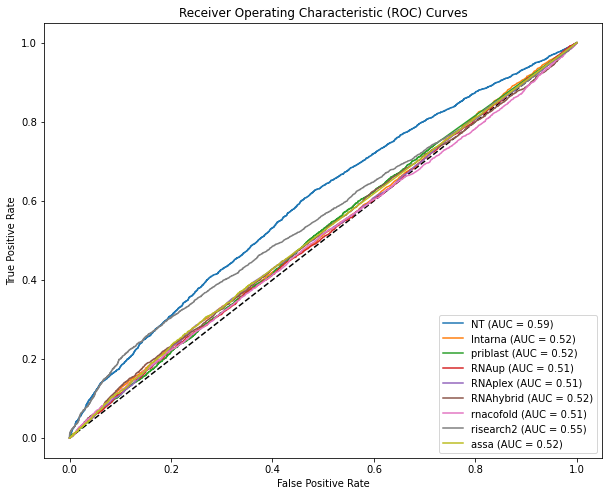

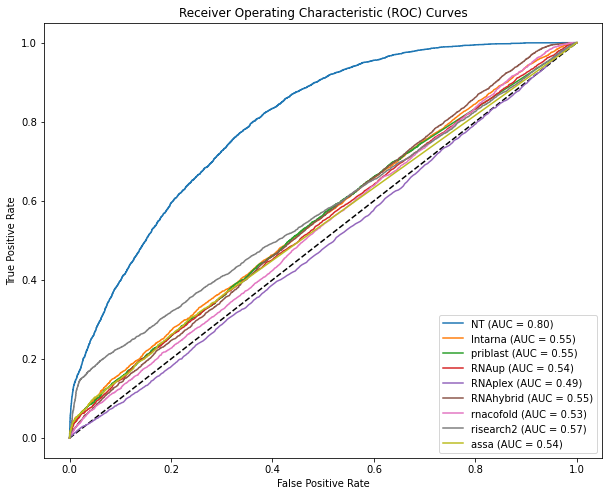




# excluded couples:  234
DATASET: ricseq


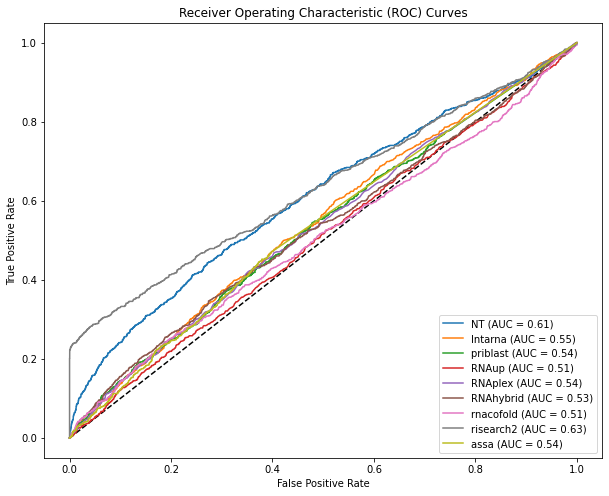

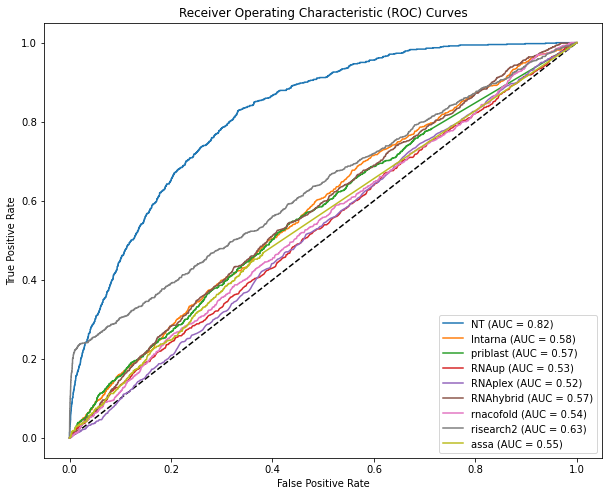




# excluded couples:  12
DATASET: splash


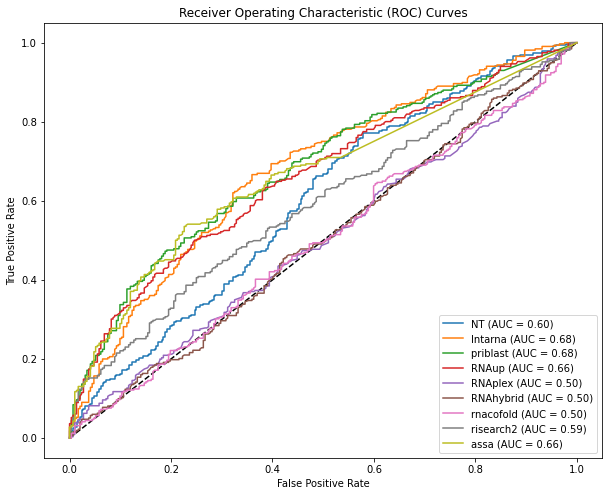

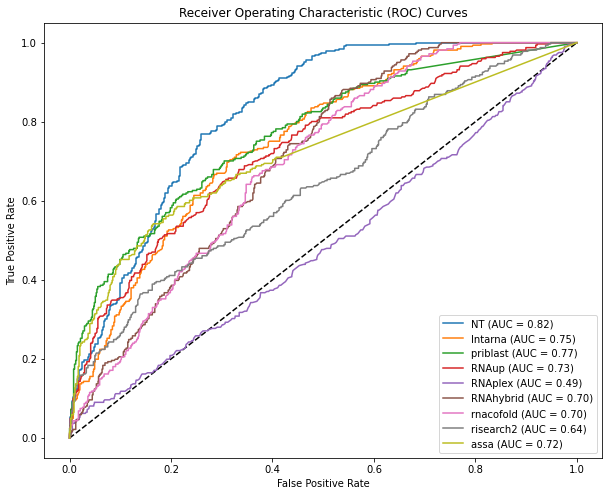




# excluded couples:  4
DATASET: mario


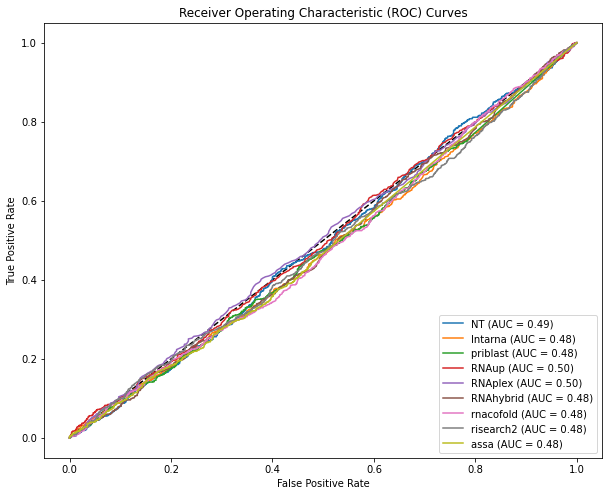

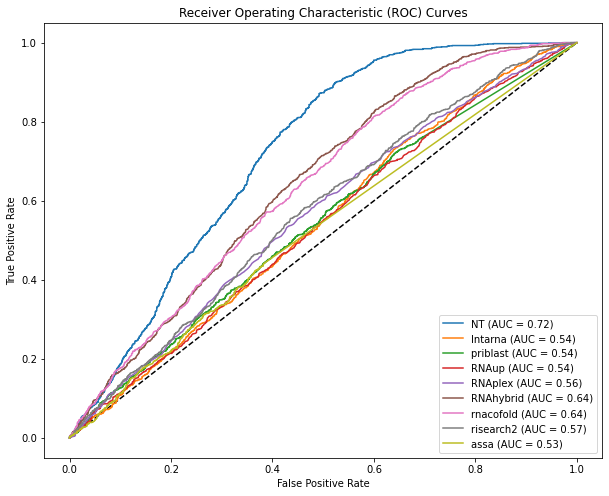

In [21]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS)
    for model_column in energy_columns:
        lrm_dict = logistic_regression_models[model_column]
        X_test = np.expand_dims(res[model_column], 1)
        y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
        res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping
    
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    
    
    m = obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    m = obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1)
    m['model_name'] = m['model_name'] + '_logistic'
    dfs.append(m)
    
    
    print(f'DATASET: {dataset}')
    plot_all_model_auc(easypos_smartneg, tools)
    plot_all_model_auc(ephnen, tools)
    print('\n\n')

In [22]:
df_auc2 = pd.concat(dfs, axis = 1)
df_auc2 = df_auc2.loc[:,~df_auc2.columns.duplicated()].copy()

In [23]:
errors = df_auc.drop('model_name', axis =1 ) - df_auc2.drop('model_name', axis =1 )

In [24]:
errors['model_name'] = df_auc['model_name']

In [25]:
errors

auc_EPSN_paris  auc_EPENHN_paris  auc_EPSN_ricseq  auc_EPENHN_ricseq  \
0            0.00               0.0             0.00               0.00   
1            0.00               0.0            -0.01               0.00   
2            0.00               0.0             0.00              -0.01   
3            0.00               0.0            -0.01               0.00   
4            0.00               0.0             0.00               0.01   
5            0.00               0.0             0.00               0.01   
6           -0.01               0.0             0.00               0.00   
7            0.00               0.0             0.00               0.00   
8            0.00               0.0             0.00               0.00   

   auc_EPSN_splash  auc_EPENHN_splash  auc_EPSN_mario  auc_EPENHN_mario  \
0             0.00               0.00             0.0               0.0   
1             0.00               0.00             0.0               0.0   
2             0.00               0.00             0.0               0.0   
3             0.00               0.00             0.0               0.0   
4             0.00               0.00             0.0               0.0   
5             0.00               0.00             0.0               0.0   
6             0.00              -0.01             0.0               0.0   
7             0.00               0.00             0.0               0.0   
8             0.01               0.00             0.0               0.0   

  model_name  
0         NT  
1    INTARNA  
2   priblast  
3      RNAup  
4    RNAplex  
5  RNAhybrid  
6  rnacofold  
7  risearch2  
8       assa

In [26]:
# Open the file in binary write mode and serialize the dictionary
with open(LR_MAPPING_PATH, 'wb') as file:
    pickle.dump(logistic_regression_models, file)

# Model comparison

In [7]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

In [8]:
def obtain_subset_from_task(res, task):

    if task == 'patches':
        subset_to_plot = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)

    elif task == 'interactors':
        subset_to_plot = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
        
    return subset_to_plot

In [9]:
def plot_results_of_all_models(datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = True, balance_at_each_step = True):
    
    for dataset in datasets:
        print(f'##############   ##############   ##############   ##############   ##############')
        how = dataset if dataset != 'paris' else 'test'
        for task in ['patches500', 'patches', 'interactors']:
            if task == 'patches500': 

                enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                     args_datasets[how]['only_test'], 
                                     args_datasets[how]['exclude_train_genes'], 
                                     args_datasets[how]['exclude_paris_genes'], 
                                     args_datasets[how]['exclude_paris_couples'],
                                     args_datasets[how]['filter_hq_ricseq'], 
                                     args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                     SPECIE_PARIS, True)

                pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                     args_datasets[how]['only_test'], 
                                     args_datasets[how]['exclude_train_genes'], 
                                     args_datasets[how]['exclude_paris_genes'], 
                                     args_datasets[how]['exclude_paris_couples'],
                                     args_datasets[how]['filter_hq_ricseq'], 
                                     args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                     SPECIE_PARIS, False)

                pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
                res = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)

            else:
                res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS, False)
                res = obtain_subset_from_task(res, task)

            for model_column in energy_columns:
                lrm_dict = logistic_regression_models[model_column]
                X_test = np.expand_dims(res[model_column], 1)
                y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
                res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

            for metric in list_of_metrics:
                print(f'---------- DATASET: {dataset} ----------')
                print(f'           -- -- -- {task} -- -- -- ')
                print(f'           -  -  -  {metric}  -  -  - ')

                subset_to_plot = balance_df(res).reset_index(drop = True)

                plt.figure(figsize=figsize)
                
                if based_on_threshold:
                    plot_function = plot_results_based_on_treshold_for_all_models(subset_to_plot, MIN_PERC = MIN_PERC, 
                                                                                  list_of_models_to_test = list_of_models_to_test, 
                                                                                  n_values = n_values, n_run_undersampling = n_run_undersampling, 
                                                                                  metric = metric, task_name = task, 
                                                                                  size_multiplier = size_multiplier, 
                                                                                  balance_at_each_step = balance_at_each_step
                                                                                 )
                else:
                    plot_results_based_on_topbottom_for_all_models
                    plot_results_based_on_topbottom_for_all_models(subset_to_plot, MIN_PERC = MIN_PERC, 
                                                                   list_of_models_to_test = list_of_models_to_test, 
                                                                   n_values = n_values, n_run_undersampling = n_run_undersampling, 
                                                                   metric = metric, task_name = task, 
                                                                   size_multiplier = 0, 
                                                                  )
                plt.show()

            print('\n\n')

### Plots based on threshold

#### Come mai bilancio ad ogni step i pred_pos e i pred_neg? 

Supponiamo di avere livello di confidenza 0.9

qui abbiamo 10 sample di pred_pos, e 1000 sample di pred_neg. nei pred_pos li azzecchiamo tutti (erano tutti positivi) e nei pred neg facciamo 85% di accuracy sui negativi. Questo vuol dire che abbiamo:

- TP = 10
- TN = 850
- FN = 150
- FP = 0

Se calcoliamo la recall:

10/160 = 0.06

fa cagare. 

Se invece bilancio, avremmo:

- TP = 1000
- TN = 850
- FN = 150
- FP = 0

Se calcoliamo la recall:

1000/1150 = 0.87


In [22]:
#plot parameters
MIN_PERC = 0.5 #1 è 1%
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
n_run_undersampling = 10
list_of_metrics = ['f1'] #['f1'], ['f1', 'precision_recall_curve', 'precision', 'recall', 'npv']
figsize = (17,9)
size_multiplier = 10

balance_at_each_step = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


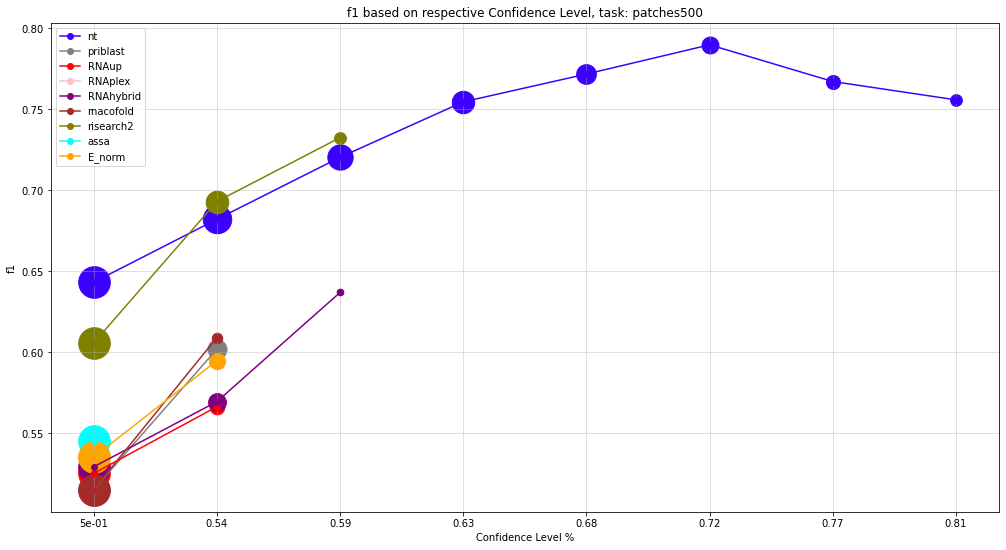




---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


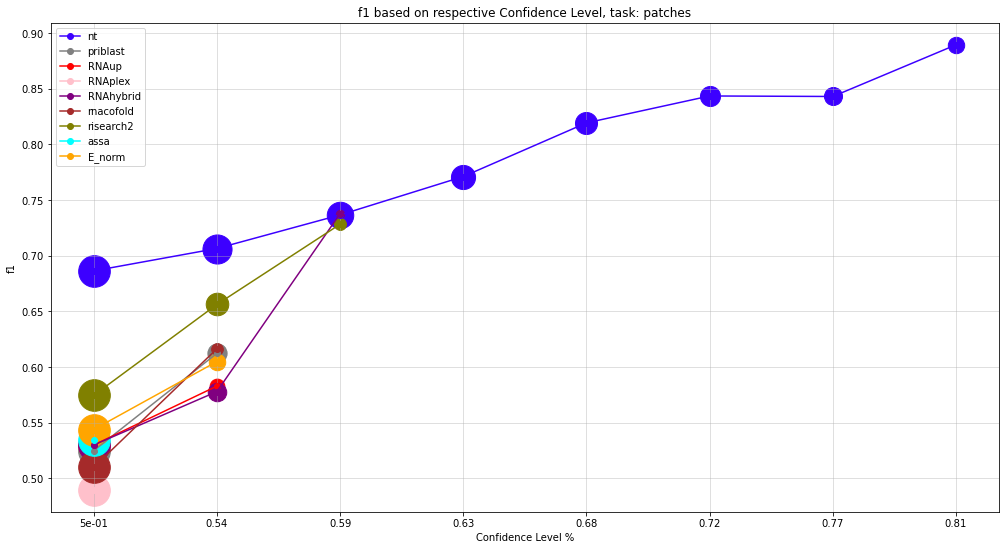




---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


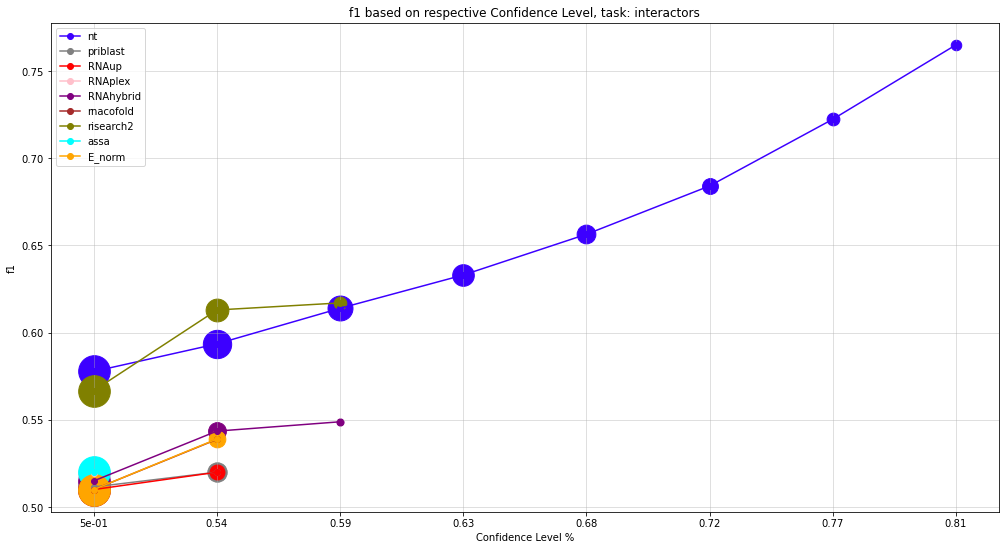




##############   ##############   ##############   ##############   ##############
# excluded couples:  234
# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


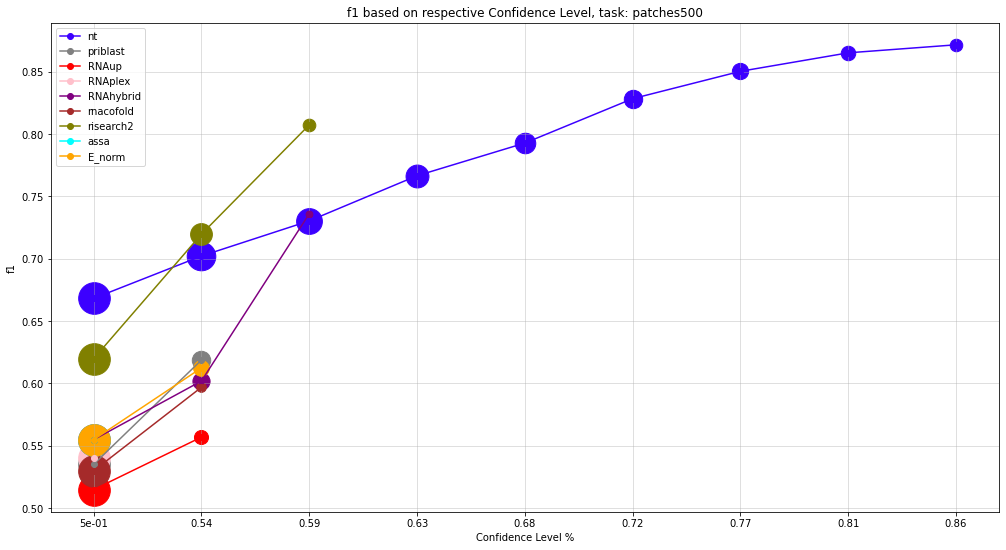




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


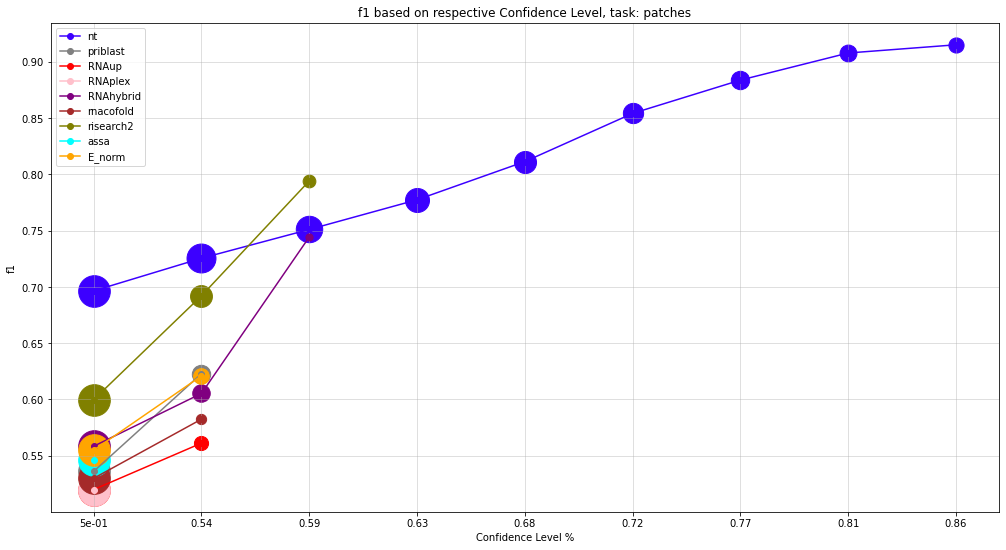




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


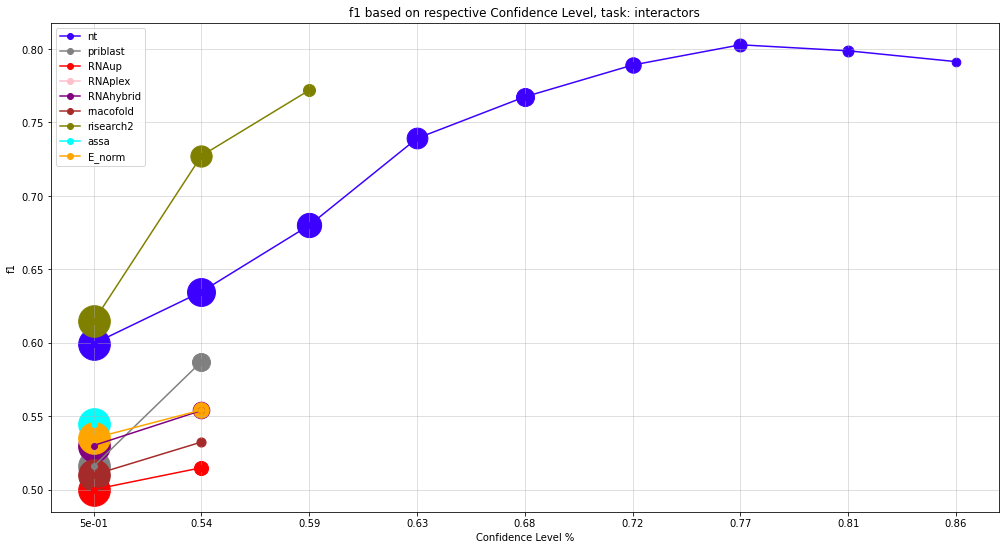




##############   ##############   ##############   ##############   ##############
# excluded couples:  12
# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


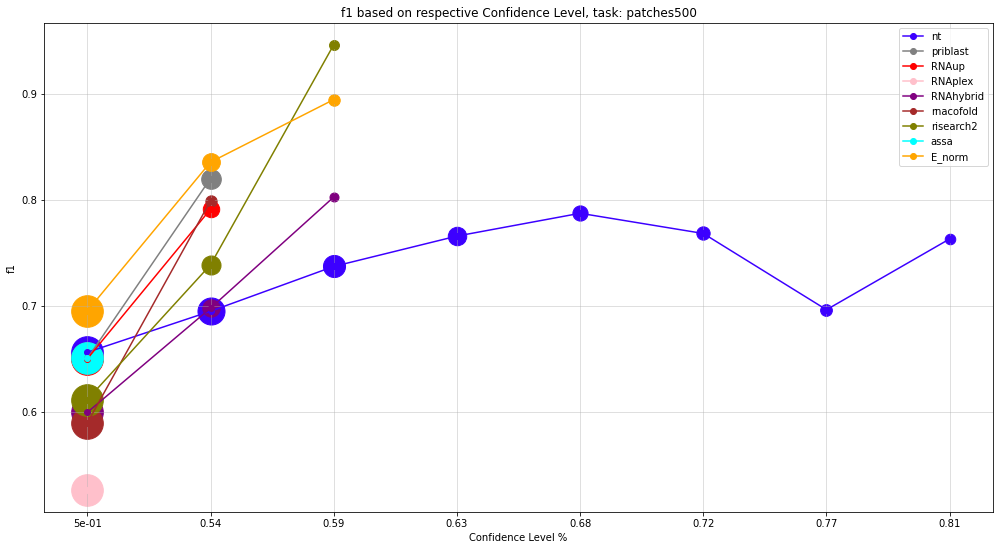




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


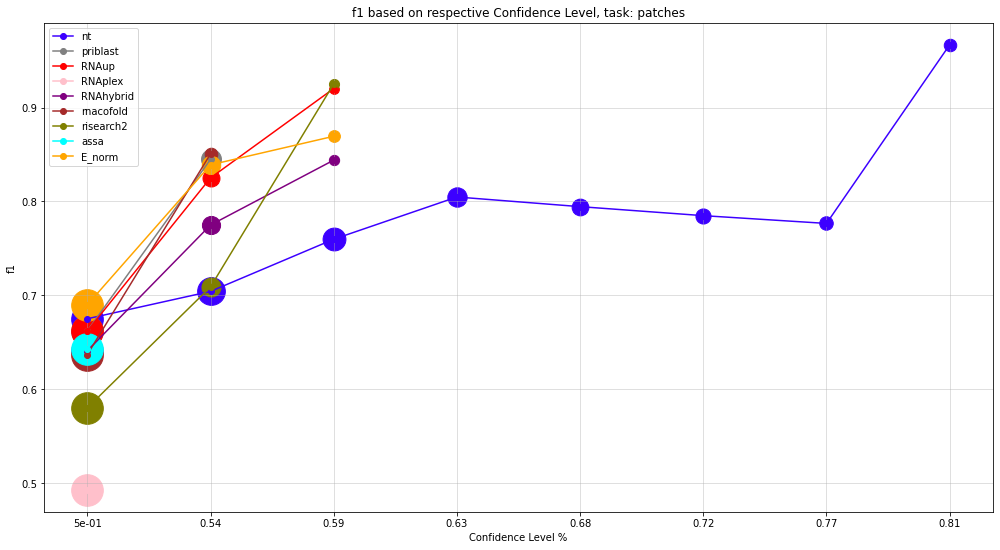




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


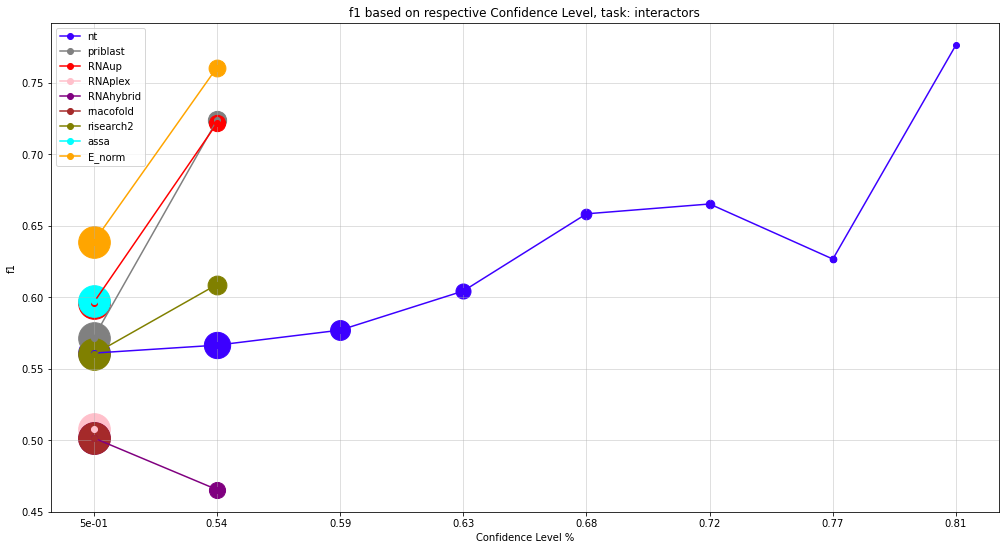




##############   ##############   ##############   ##############   ##############
# excluded couples:  4
# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  f1  -  -  - 


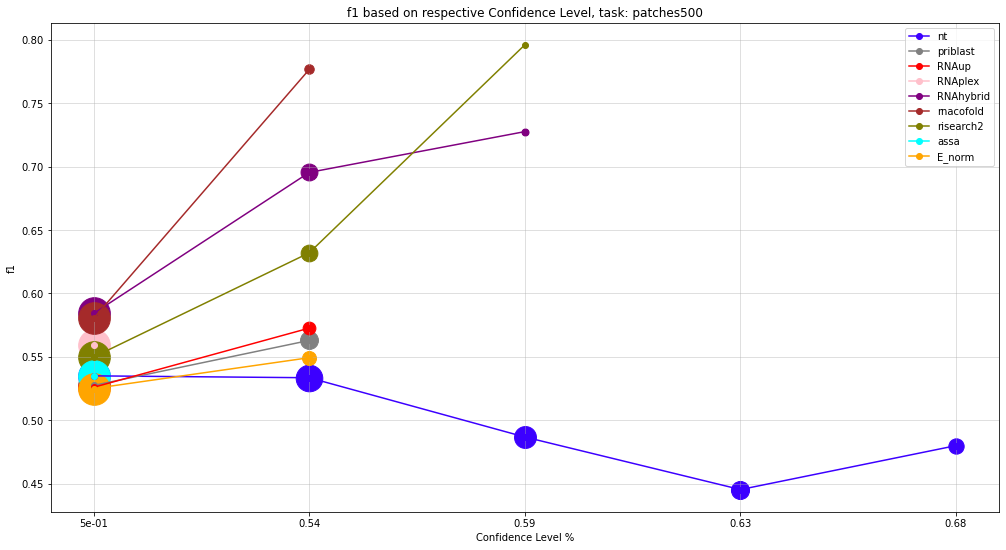




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  f1  -  -  - 


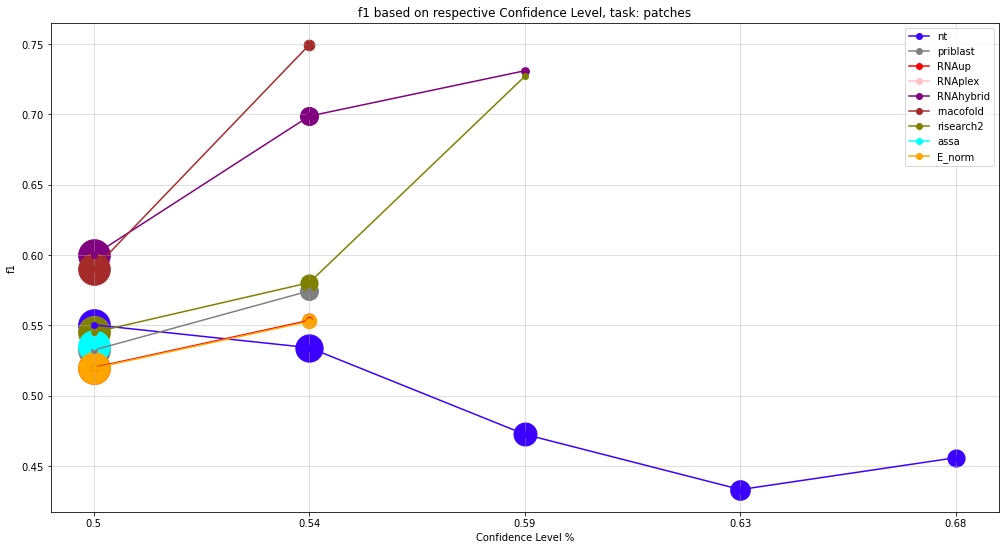




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  f1  -  -  - 


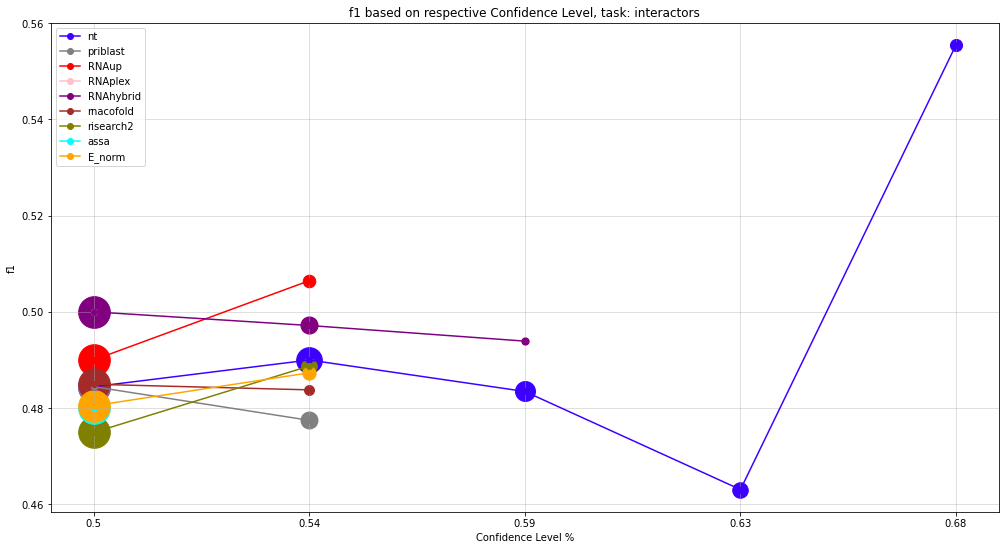

In [23]:
%load_ext autoreload
%autoreload 2
from util.plot_utils import plot_results_based_on_treshold_for_all_models

plot_results_of_all_models(datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = True, balance_at_each_step=balance_at_each_step)

### Plots based on top-bottom

In [12]:
#plot parameters
MIN_PERC = 1 
list_of_metrics = ['precision', 'npv']
balance_at_each_step=False

##############   ##############   ##############   ##############   ##############
---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


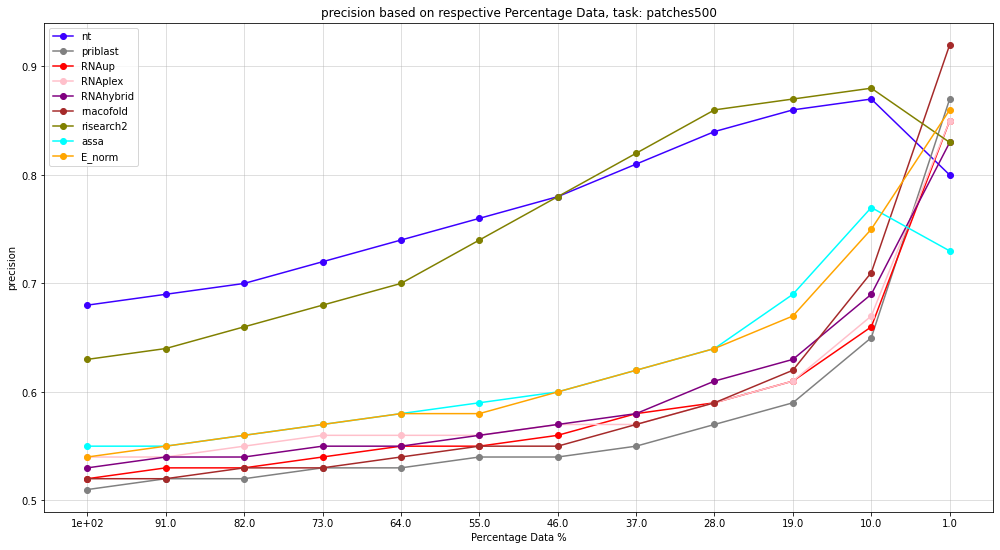

---------- DATASET: paris ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


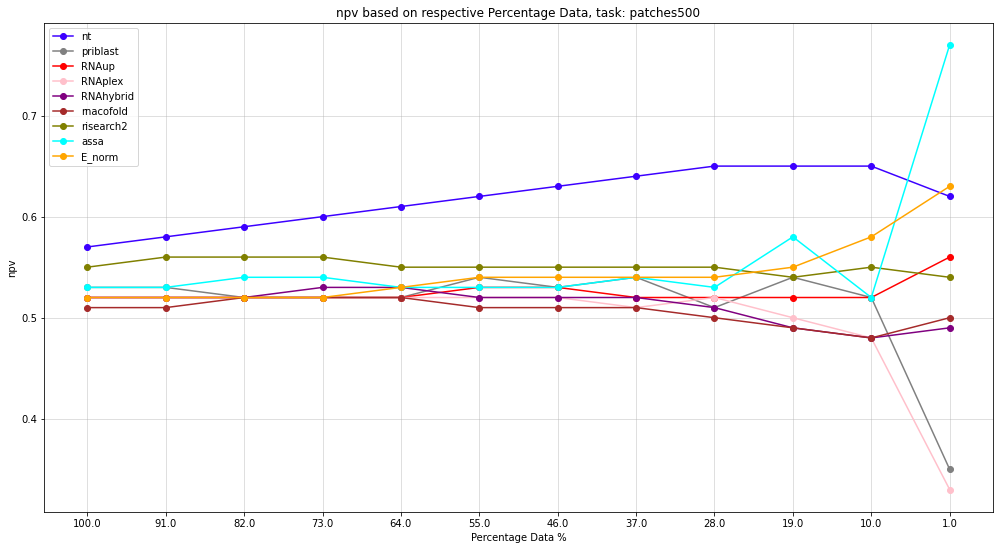




---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


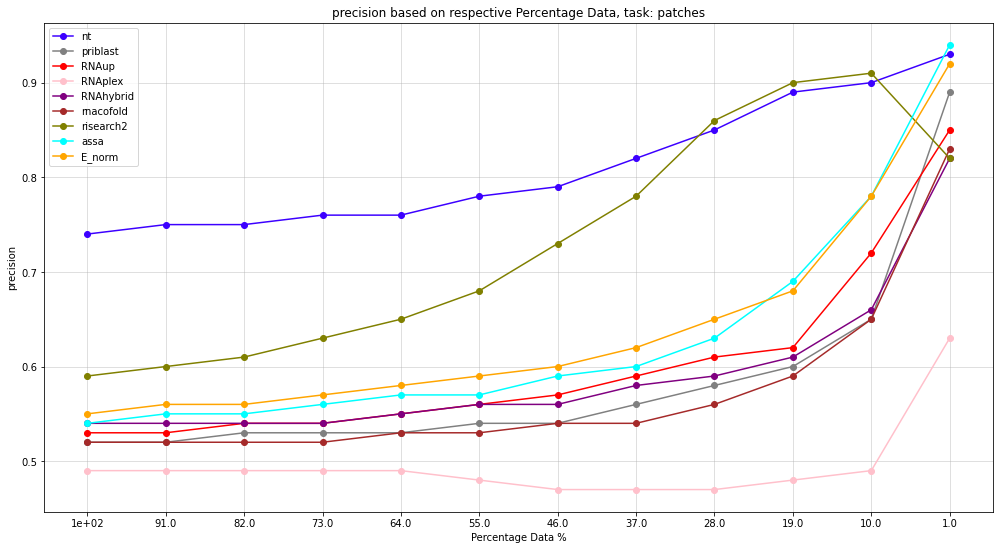

---------- DATASET: paris ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


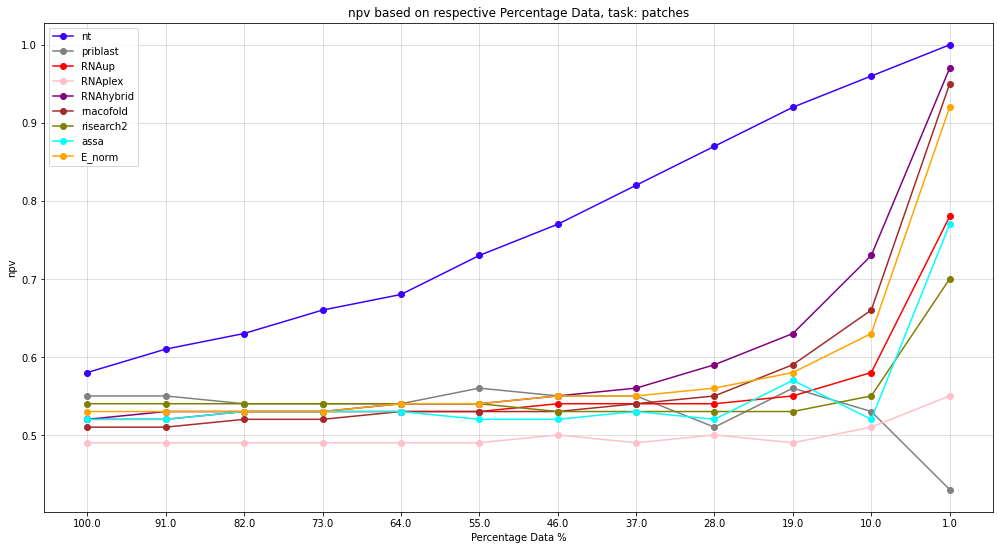




---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


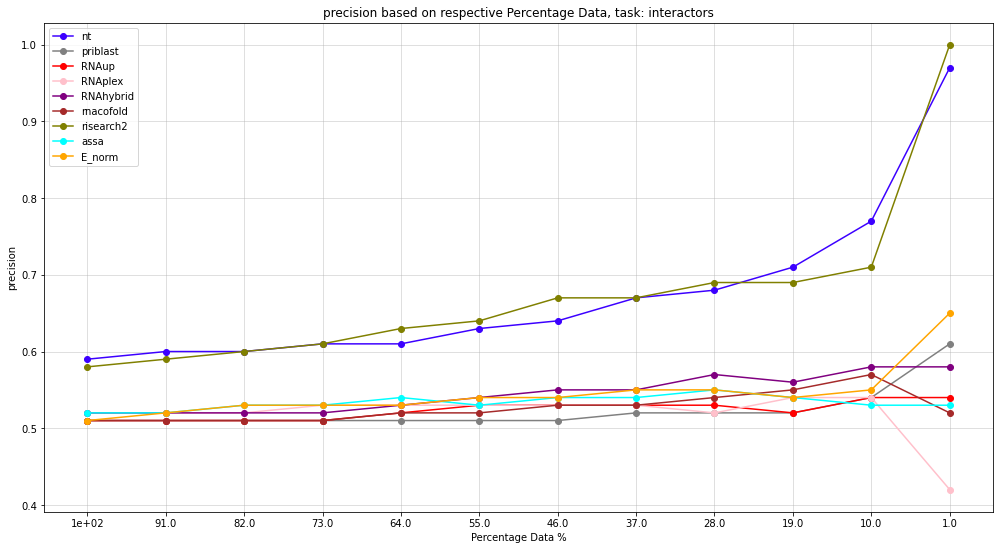

---------- DATASET: paris ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


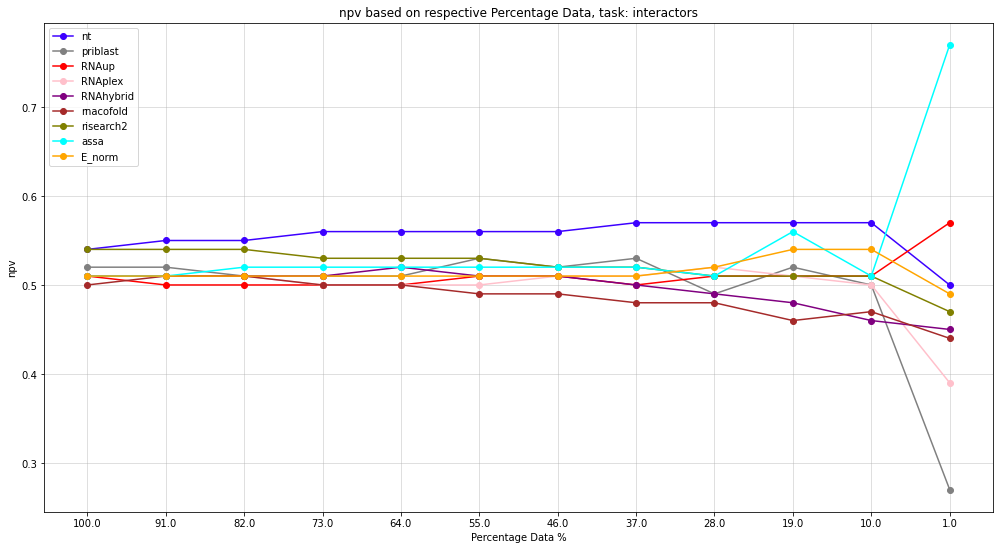




##############   ##############   ##############   ##############   ##############
# excluded couples:  234
# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


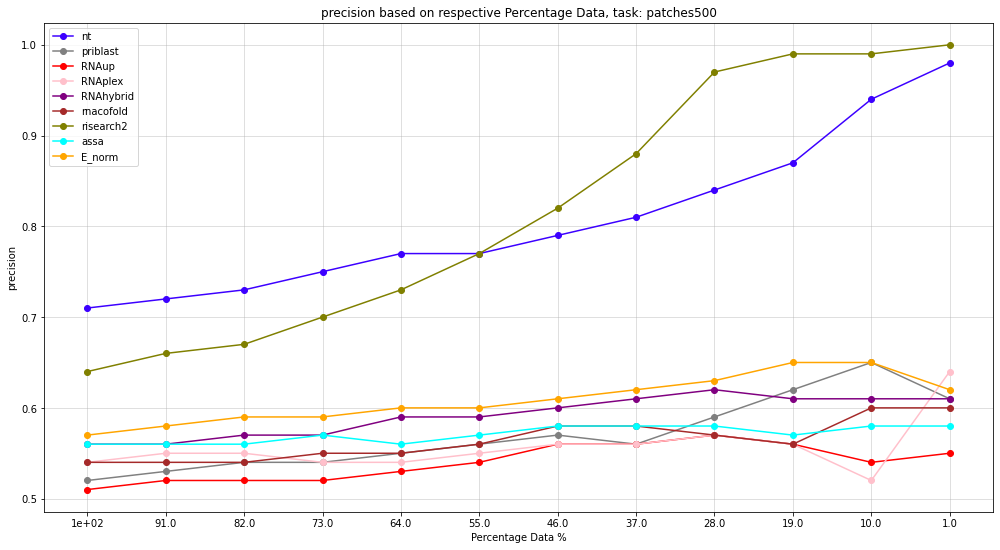

---------- DATASET: ricseq ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


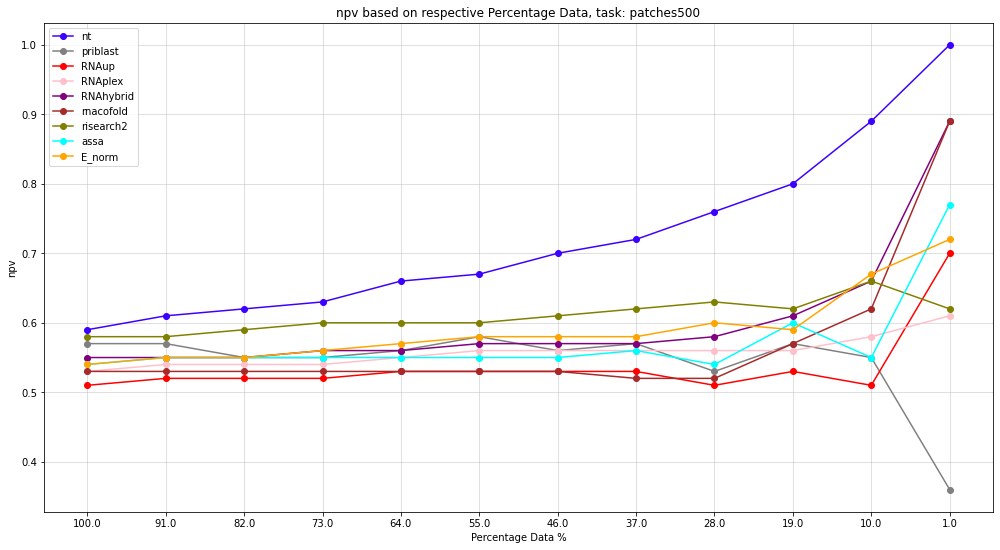




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


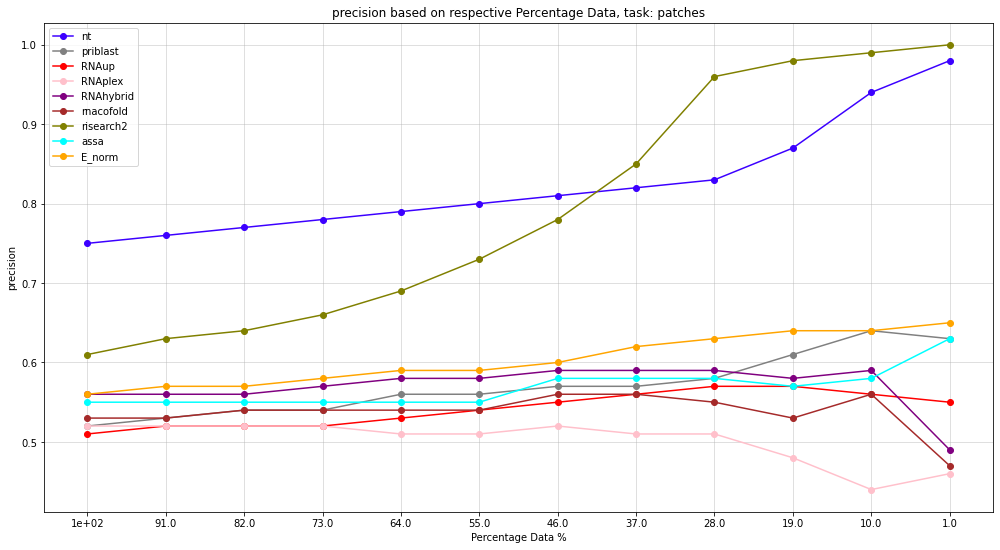

---------- DATASET: ricseq ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


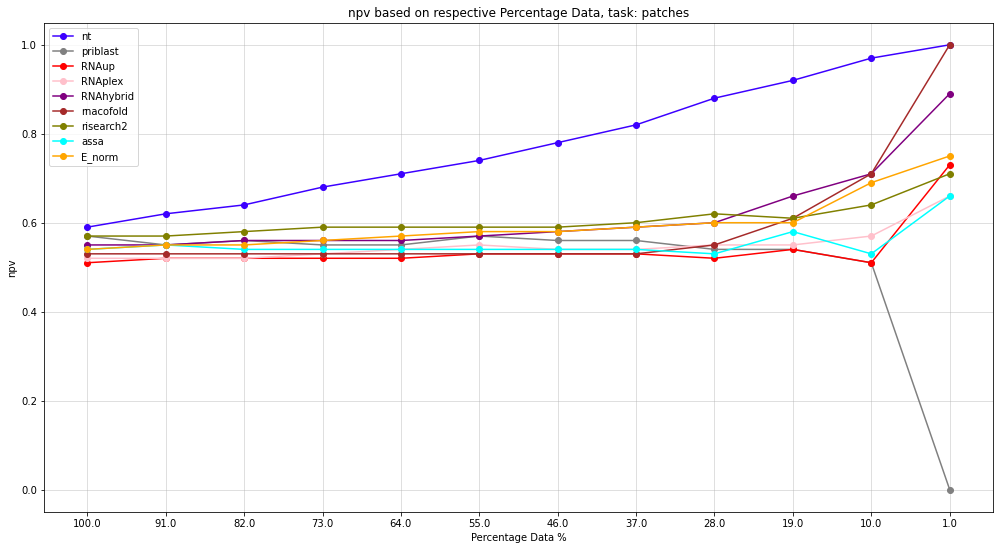




# excluded couples:  234
---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


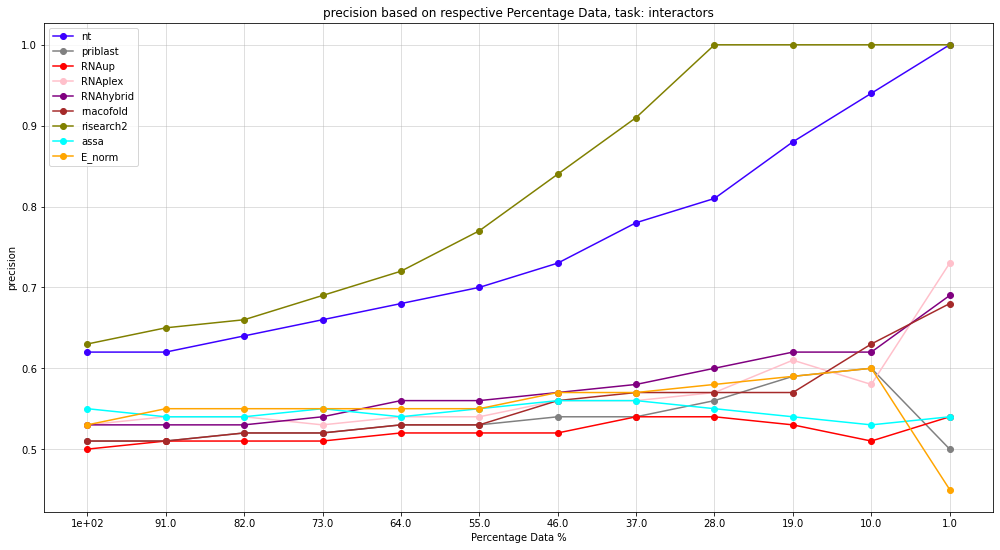

---------- DATASET: ricseq ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


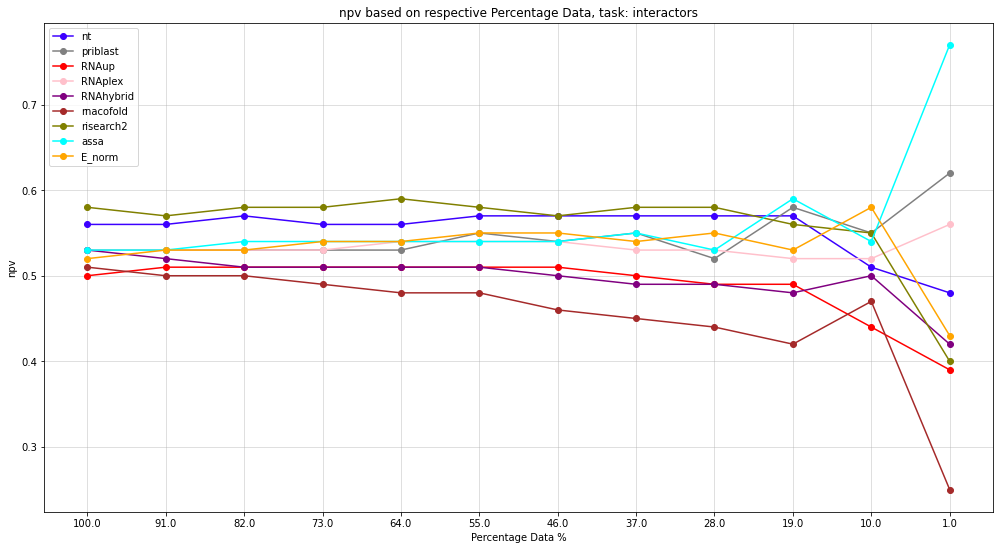




##############   ##############   ##############   ##############   ##############
# excluded couples:  12
# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


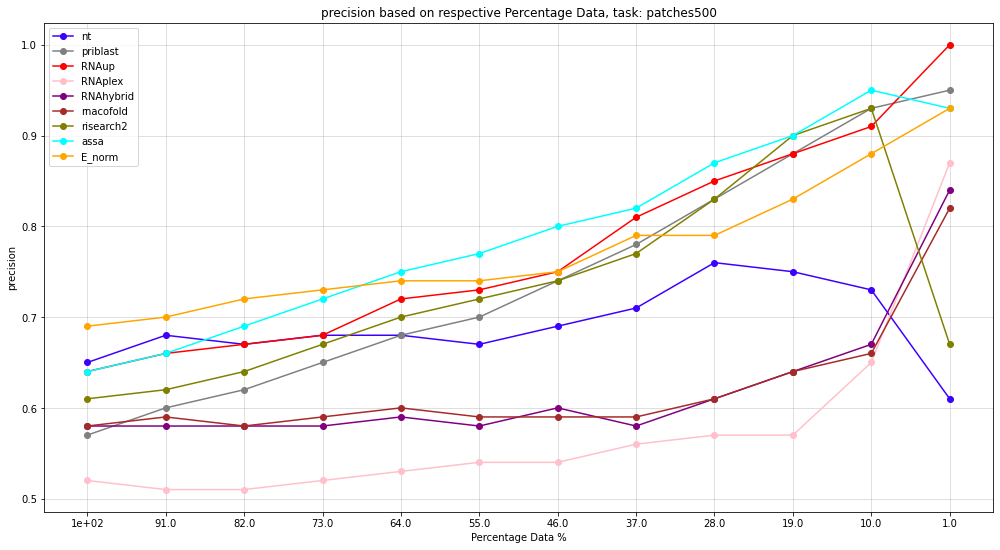

---------- DATASET: splash ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


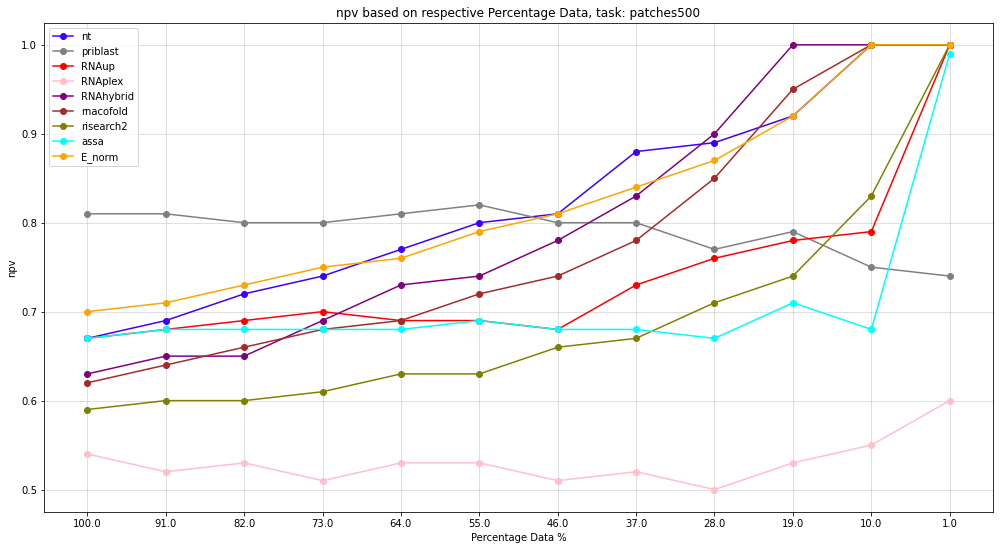




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


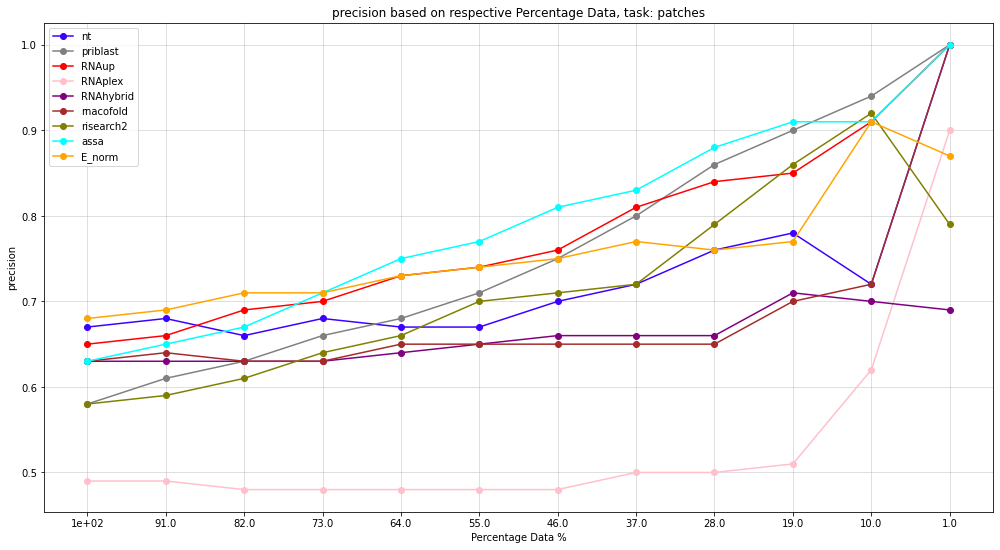

---------- DATASET: splash ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


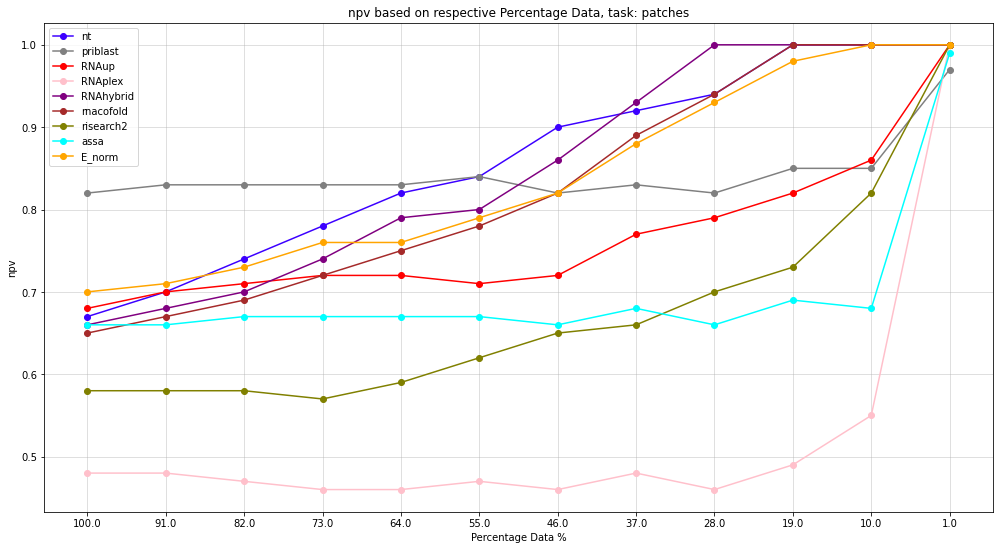




# excluded couples:  12
---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


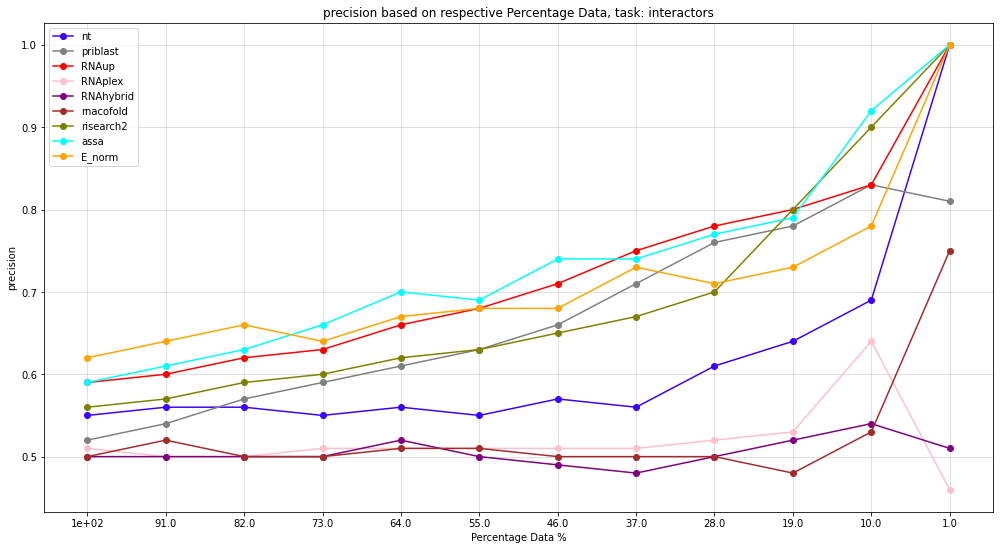

---------- DATASET: splash ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


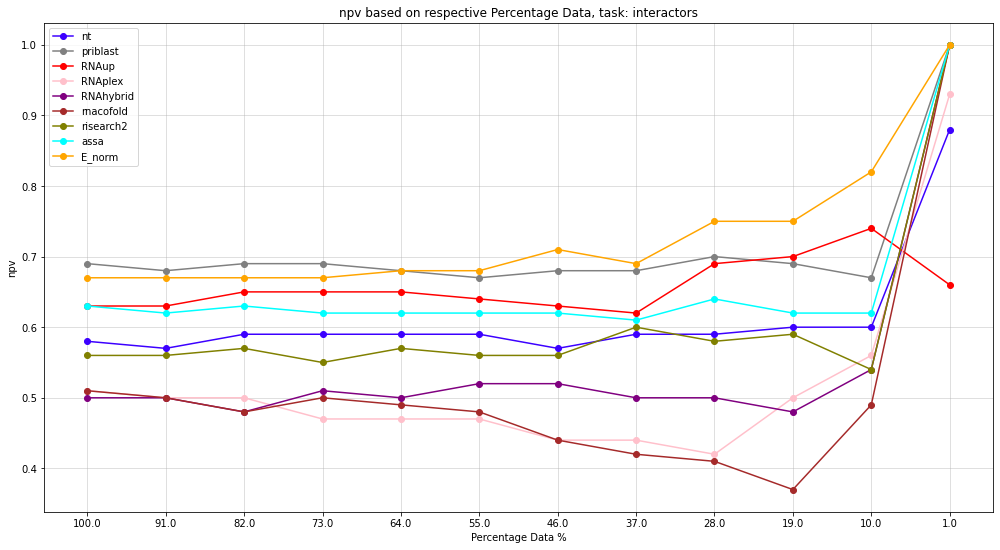




##############   ##############   ##############   ##############   ##############
# excluded couples:  4
# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  precision  -  -  - 


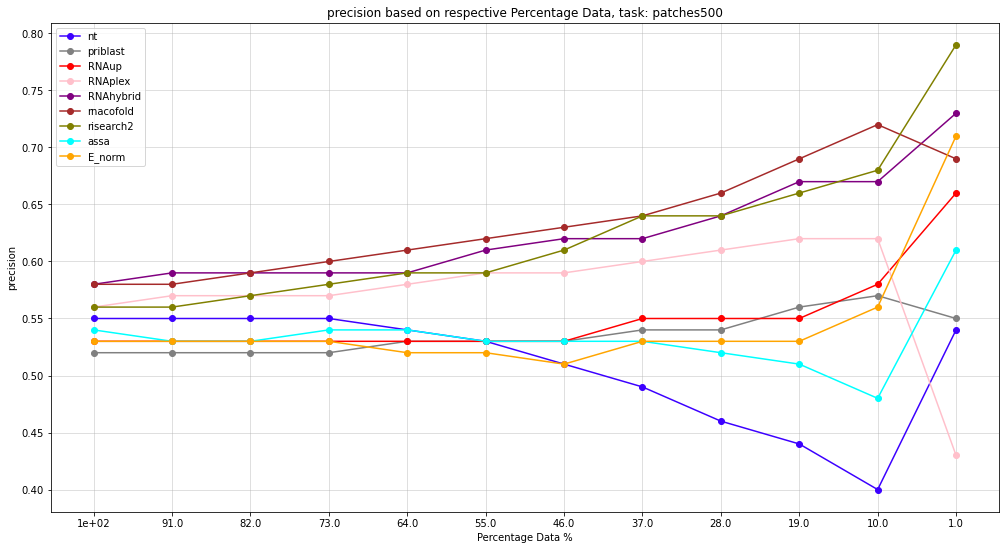

---------- DATASET: mario ----------
           -- -- -- patches500 -- -- -- 
           -  -  -  npv  -  -  - 


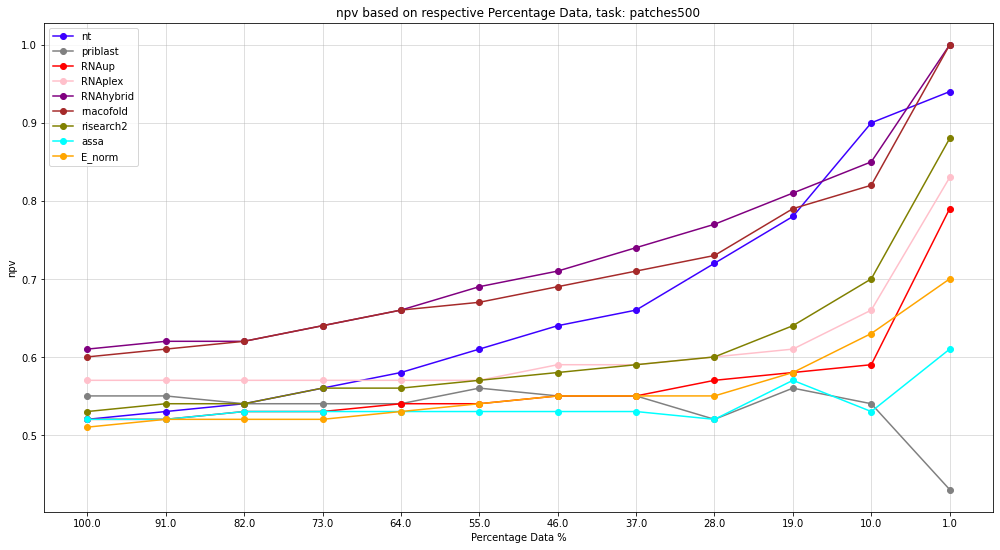




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  precision  -  -  - 


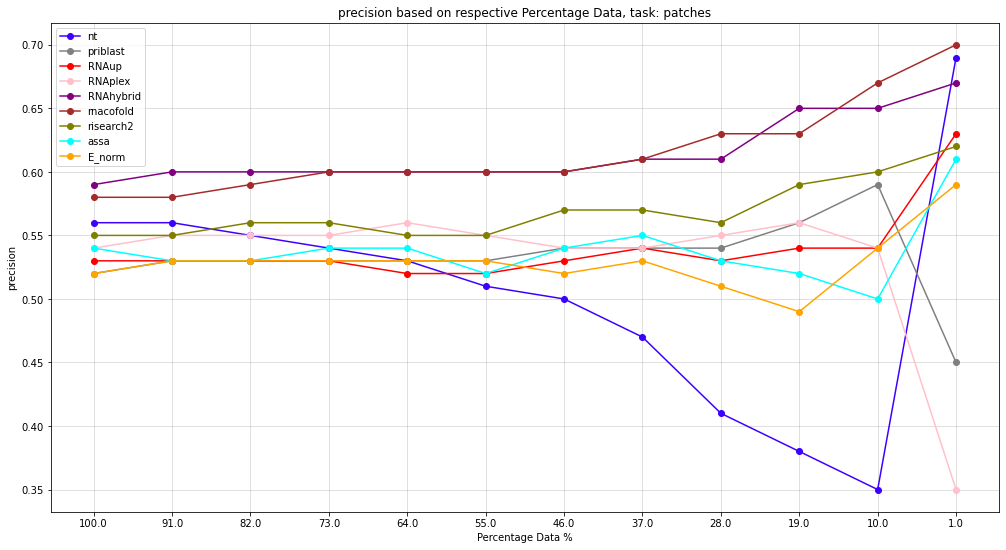

---------- DATASET: mario ----------
           -- -- -- patches -- -- -- 
           -  -  -  npv  -  -  - 


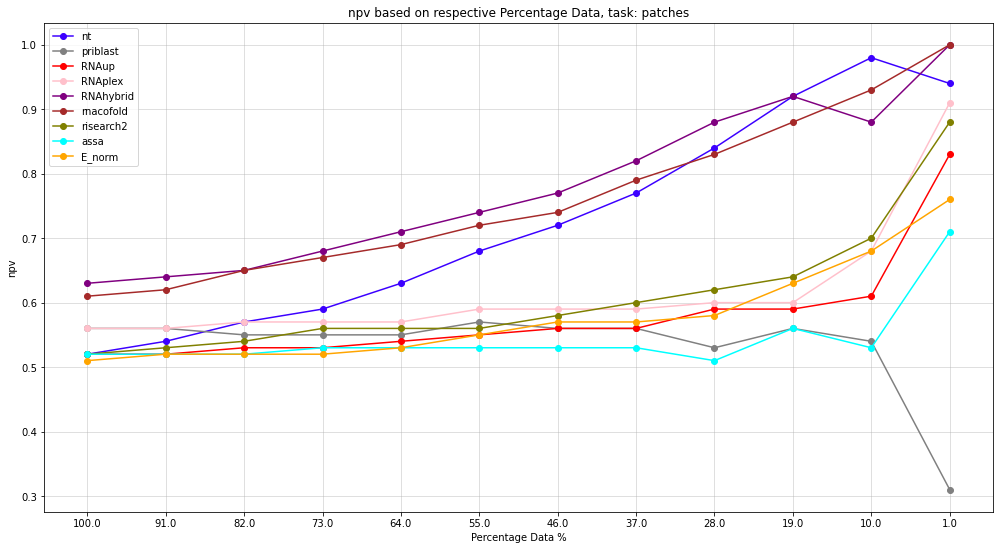




# excluded couples:  4
---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  precision  -  -  - 


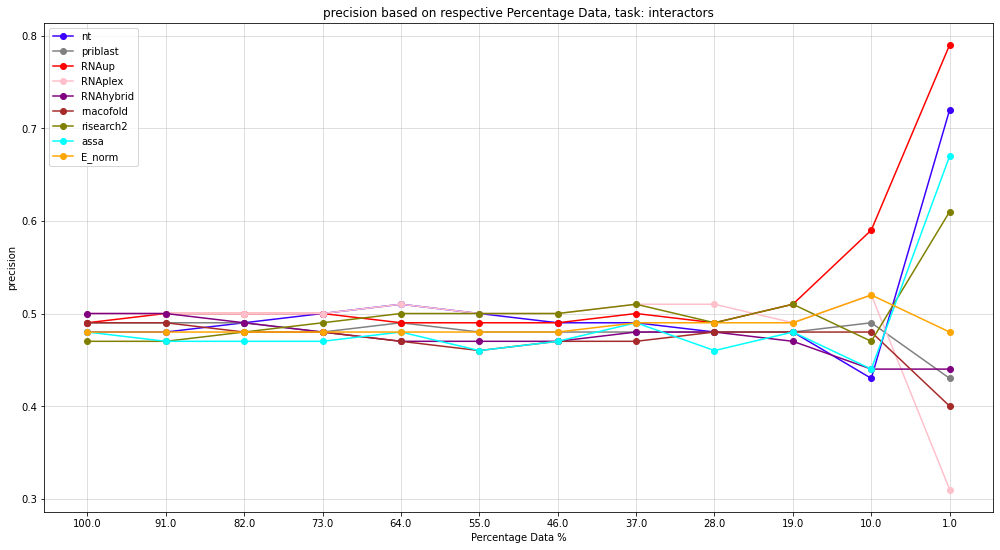

---------- DATASET: mario ----------
           -- -- -- interactors -- -- -- 
           -  -  -  npv  -  -  - 


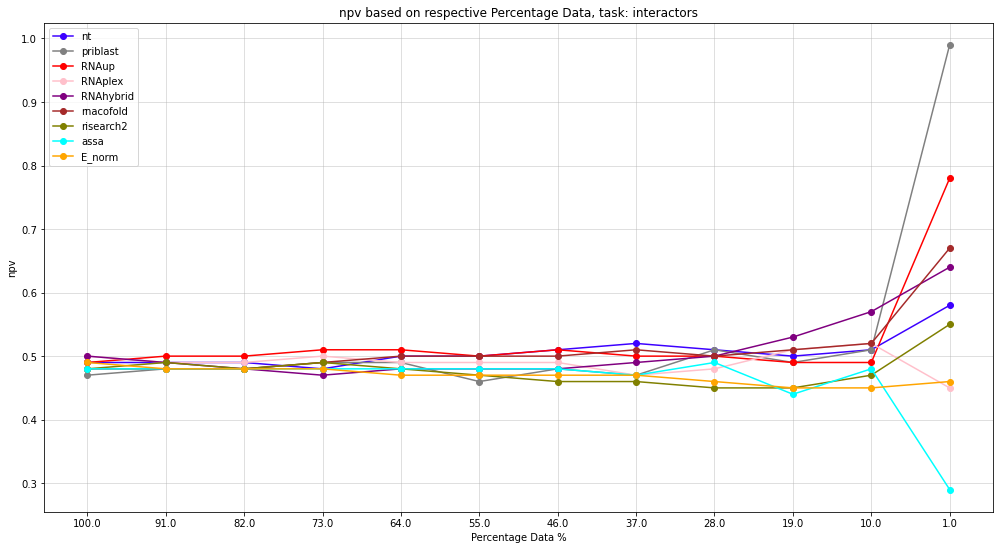

In [13]:
plot_results_of_all_models(datasets, args_datasets, energy_columns, MIN_PERC, list_of_models_to_test, n_values, n_run_undersampling, list_of_metrics, figsize, size_multiplier, based_on_threshold = False, balance_at_each_step=balance_at_each_step)

### Repeats enrichment

In [14]:
how = 'test'
dataset = 'paris'

In [15]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                 args_datasets[how]['only_test'], 
                 args_datasets[how]['exclude_train_genes'], 
                 args_datasets[how]['exclude_paris_genes'], 
                 args_datasets[how]['exclude_paris_couples'],
                 args_datasets[how]['filter_hq_ricseq'], 
                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                 SPECIE_PARIS, False)
#res = obtain_subset_from_task(res, 'interactors')

for model_column in energy_columns:
    lrm_dict = logistic_regression_models[model_column]
    X_test = np.expand_dims(res[model_column], 1)
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

In [16]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'test500.csv'))

feature_to_search = 'Simple_repeat' #'Simple_repeat' 'Low_complexity' 'SINE'

full_overlap = False

if full_overlap:
    suffix = 'full_'
else:
    suffix = ''

sr1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples)
sr2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples)

none1 = set(test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples)
none2 = set(test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples)

res['simple_repeat1'] = res.id_sample.isin(sr1)
res['simple_repeat2'] = res.id_sample.isin(sr2)
res['none1'] = res.id_sample.isin(none1)
res['none2'] = res.id_sample.isin(none2)

In [24]:
both_sr = False

filtered_policies = ['easypos', 'smartneg']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]

no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

N_total_couples = len(set(res[res.policy.isin(filtered_policies)].id_sample))

print(f'{feature_to_search} are the {len(set(sr.id_sample)) /  N_total_couples * 100}  % of the total couples')
print(f'No {feature_to_search} are the {len(set(no_sr.id_sample)) /  N_total_couples * 100}  % of the total couples')



sr_ep = sr[sr.policy == 'easypos'].reset_index(drop = True)
sr_sn = sr[sr.policy == 'smartneg'].reset_index(drop = True)

no_sr_ep = no_sr[no_sr.policy == 'easypos'].reset_index(drop = True)
no_sr_sn = no_sr[no_sr.policy == 'smartneg'].reset_index(drop = True)

Simple_repeat are the 25.59480138350278  % of the total couples
No Simple_repeat are the 74.40519861649723  % of the total couples


In [25]:
def make_plot_kde_and_test_difference(x, y, label_x, label_y, title, figsize):
    plt.figure(figsize=figsize)
    sns.kdeplot(x, common_norm=True, label = label_x)
    sns.kdeplot(y, common_norm=True,  label = label_y)
    plt.legend()
    plt.title(f'{title}')
    plt.show()
    # Test di Kolmogorov-Smirnov
    ks_statistic, ks_p_value = np.round(stats.ks_2samp(x, y), 10)
    print(f"Test di Kolmogorov-Smirnov:\nStatistiche KS: {ks_statistic}\nP-value: {ks_p_value}\n")

    # Test di Mann-Whitney U
    mwu_statistic, mwu_p_value = np.round(stats.mannwhitneyu(x, y, alternative='two-sided'), 10)
    print(f"Test di Mann-Whitney U:\nStatistiche U: {mwu_statistic}\nP-value: {mwu_p_value}")
    
    print('\n\n')

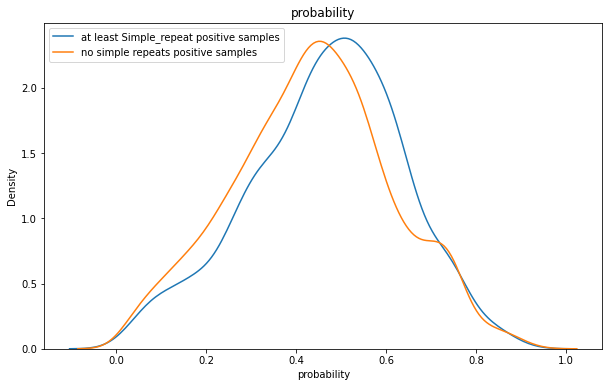

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1092932907
P-value: 1.5e-09

Test di Mann-Whitney U:
Statistiche U: 2253630.0
P-value: 7.1e-09





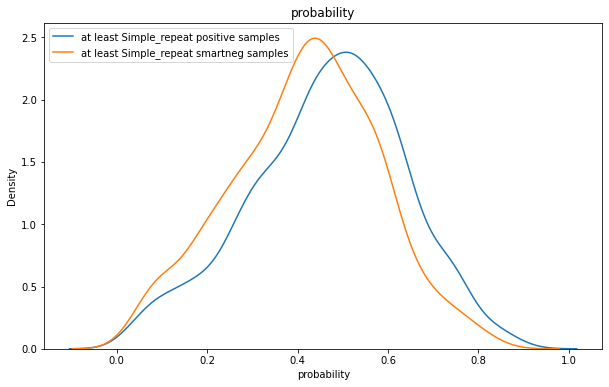

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1522212001
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 876706.0
P-value: 0.0





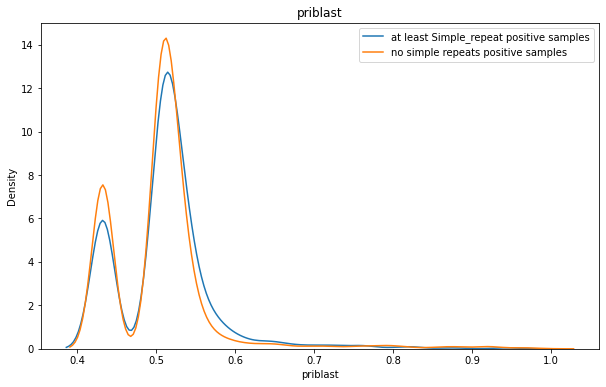

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0908049457
P-value: 1.0028e-06

Test di Mann-Whitney U:
Statistiche U: 2230556.0
P-value: 1.537e-07





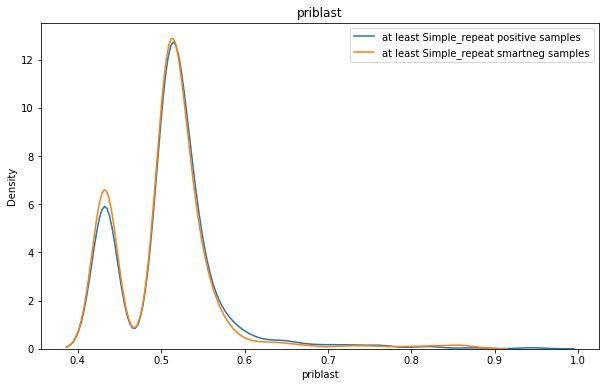

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0552019068
P-value: 0.0463743655

Test di Mann-Whitney U:
Statistiche U: 785950.0
P-value: 0.0153946779





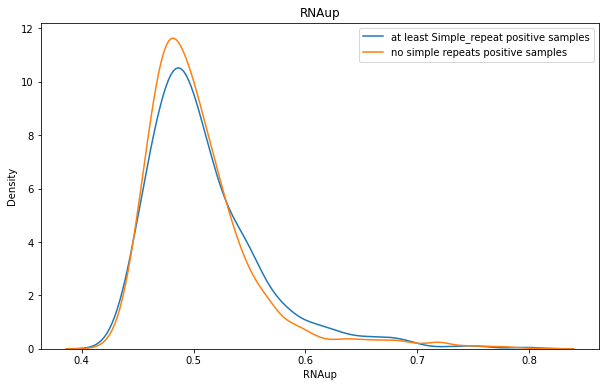

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0581513482
P-value: 0.0051546885

Test di Mann-Whitney U:
Statistiche U: 2142957.5
P-value: 0.0027870594





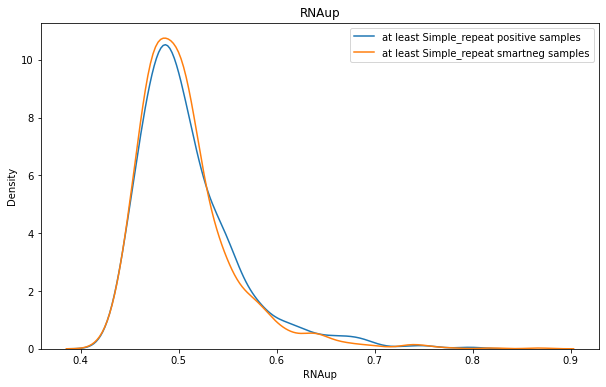

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0509926169
P-value: 0.0802768725

Test di Mann-Whitney U:
Statistiche U: 772156.0
P-value: 0.1066000804





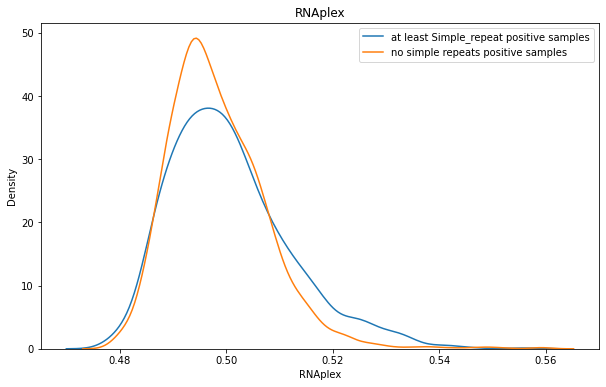

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0904839118
P-value: 1.1107e-06

Test di Mann-Whitney U:
Statistiche U: 2224855.5
P-value: 4.163e-07





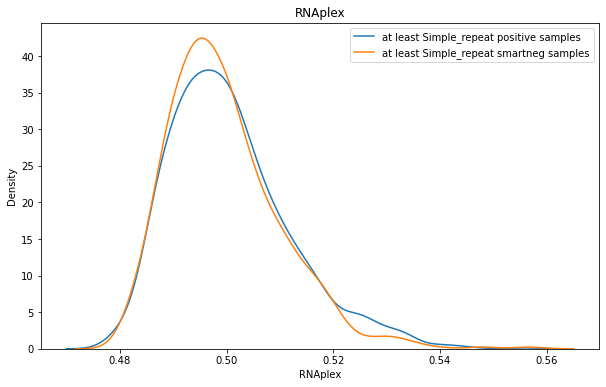

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0517694271
P-value: 0.0727843114

Test di Mann-Whitney U:
Statistiche U: 780158.5
P-value: 0.0381316519





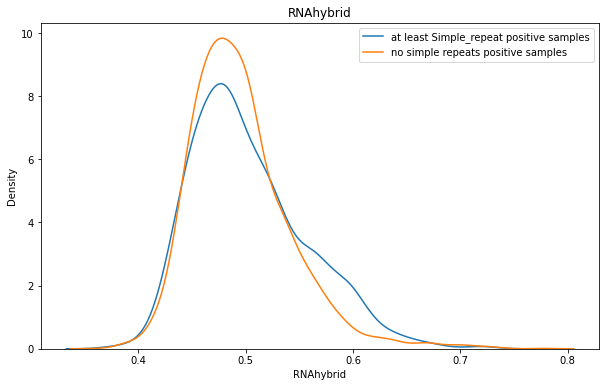

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0894684567
P-value: 1.5314e-06

Test di Mann-Whitney U:
Statistiche U: 2172075.5
P-value: 0.0001940538





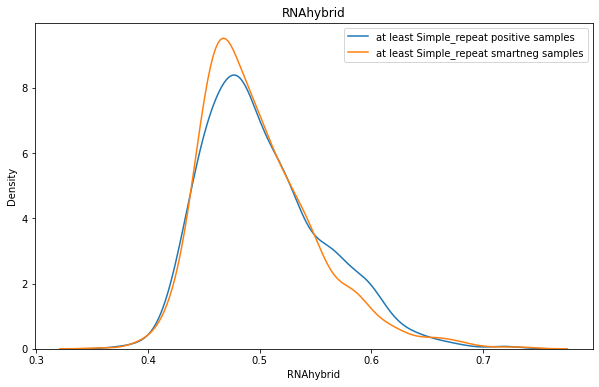

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0546690258
P-value: 0.0498236279

Test di Mann-Whitney U:
Statistiche U: 781043.0
P-value: 0.0336499107





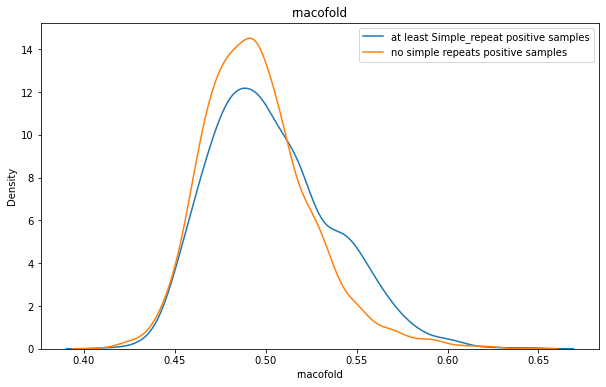

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1200244677
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 2294398.5
P-value: 0.0





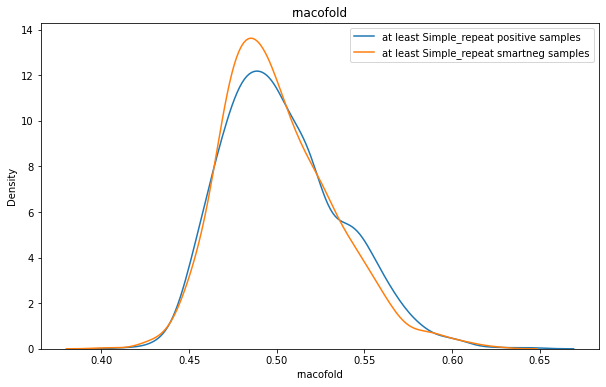

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0453123604
P-value: 0.1571421687

Test di Mann-Whitney U:
Statistiche U: 772199.0
P-value: 0.1060654078





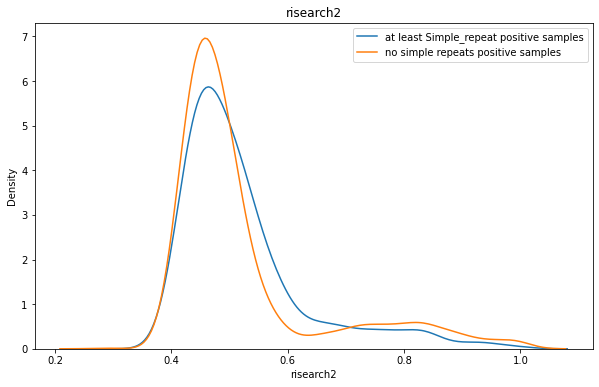

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1026775219
P-value: 1.77e-08

Test di Mann-Whitney U:
Statistiche U: 2186581.0
P-value: 4.25001e-05





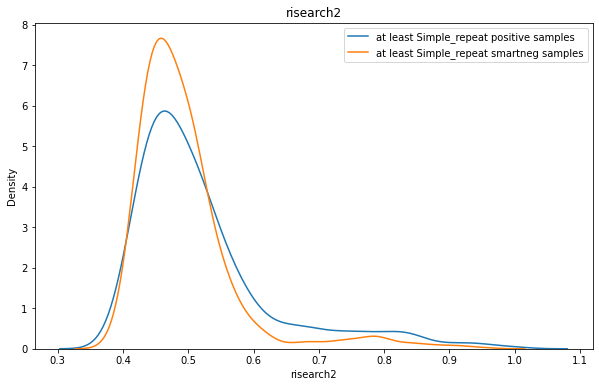

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1411960055
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 840762.0
P-value: 2.77e-08





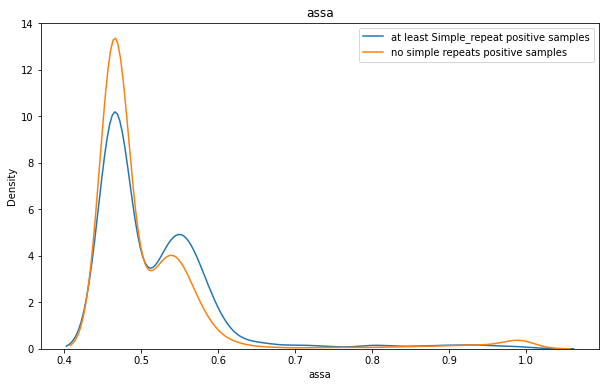

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1241482722
P-value: 0.0

Test di Mann-Whitney U:
Statistiche U: 2287565.0
P-value: 0.0





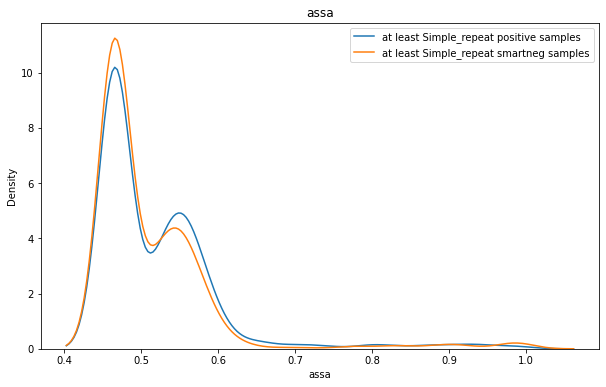

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0779719878
P-value: 0.0011232013

Test di Mann-Whitney U:
Statistiche U: 796331.0
P-value: 0.0010045902





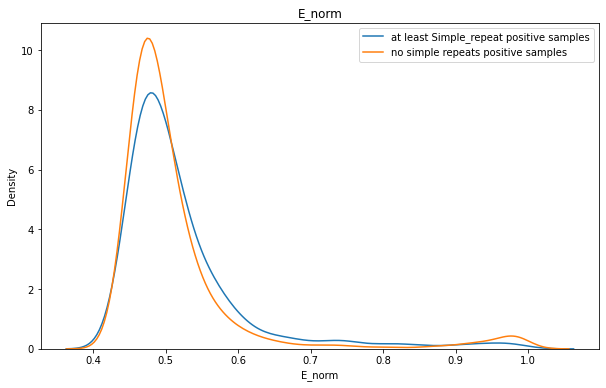

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.1001556768
P-value: 4.35e-08

Test di Mann-Whitney U:
Statistiche U: 2235485.5
P-value: 9.81e-08





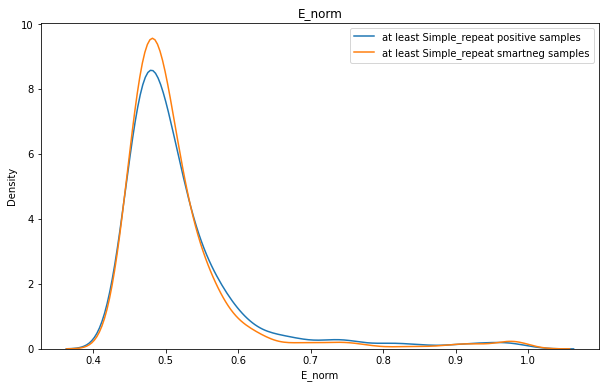

Test di Kolmogorov-Smirnov:
Statistiche KS: 0.0590489988
P-value: 0.0270357834

Test di Mann-Whitney U:
Statistiche U: 772293.0
P-value: 0.1049030268





In [26]:
figsize = (10, 6)
for column in ['probability'] + energy_columns:

    if both_sr:
        label_x = f'both {feature_to_search} positive samples'
    else:
        label_x = f'at least {feature_to_search} positive samples'

    x, y = sr_ep[column], no_sr_ep[column]
    
    make_plot_kde_and_test_difference(x, y, label_x, 'no simple repeats positive samples', column, figsize)
    
    
    
    
    if both_sr:
        label_x = f'both {feature_to_search} positive samples'
        label_y = f'both {feature_to_search} smartneg samples'
    else:
        label_x = f'at least {feature_to_search} positive samples'
        label_y = f'at least {feature_to_search} smartneg samples'

    x, y = sr_ep[column], sr_sn[column]
    
    make_plot_kde_and_test_difference(x, y, label_x, label_y, column, figsize)

    
#     if both_sr:
#         label_x = f'both {feature_to_search} positive samples, predicted as positive'
#         label_y = f'both {feature_to_search} smartneg samples, predicted as positive'
#     else:
#         label_x = f'at least {feature_to_search} positive samples, predicted as positive'
#         label_y = f'at least {feature_to_search} smartneg samples, predicted as positive'

#     x, y = sr_ep[sr_ep.probability>0.5][column], sr_sn[sr_sn.probability>0.5][column]
    
#     make_plot_kde_and_test_difference(x, y, label_x, label_y, column, figsize)

---------- DATASET: paris ----------
           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


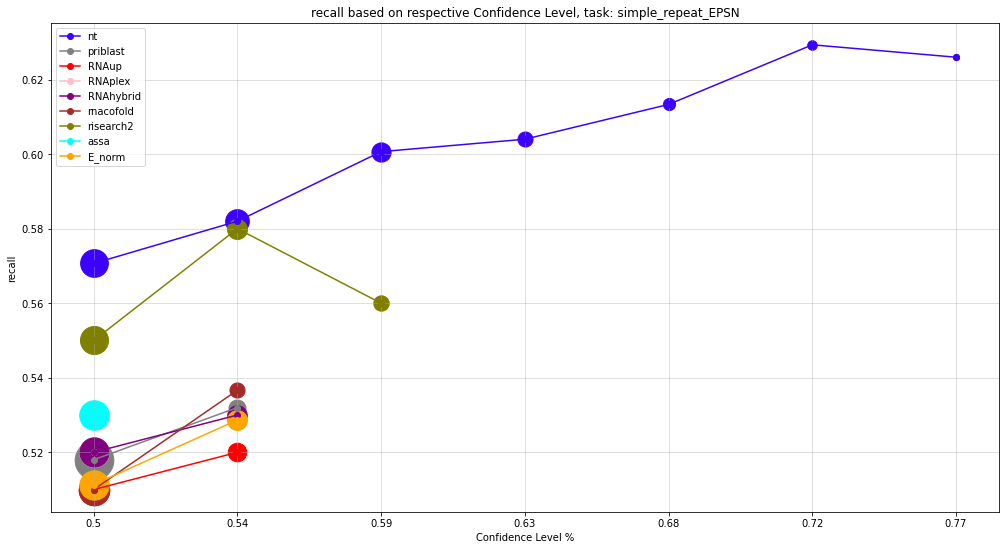

---------- DATASET: paris ----------
           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  recall  -  -  - 


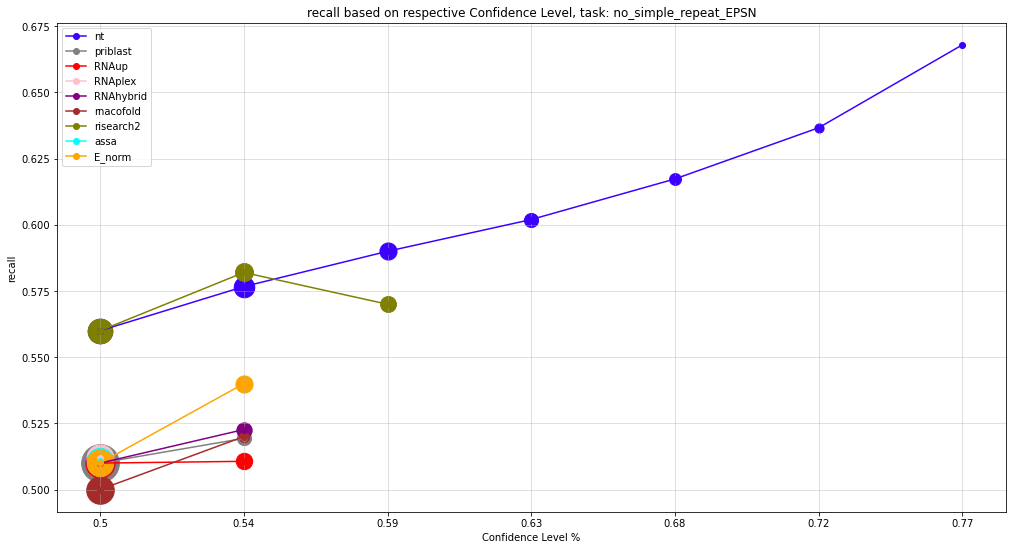

---------- DATASET: paris ----------
           -- -- -- simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


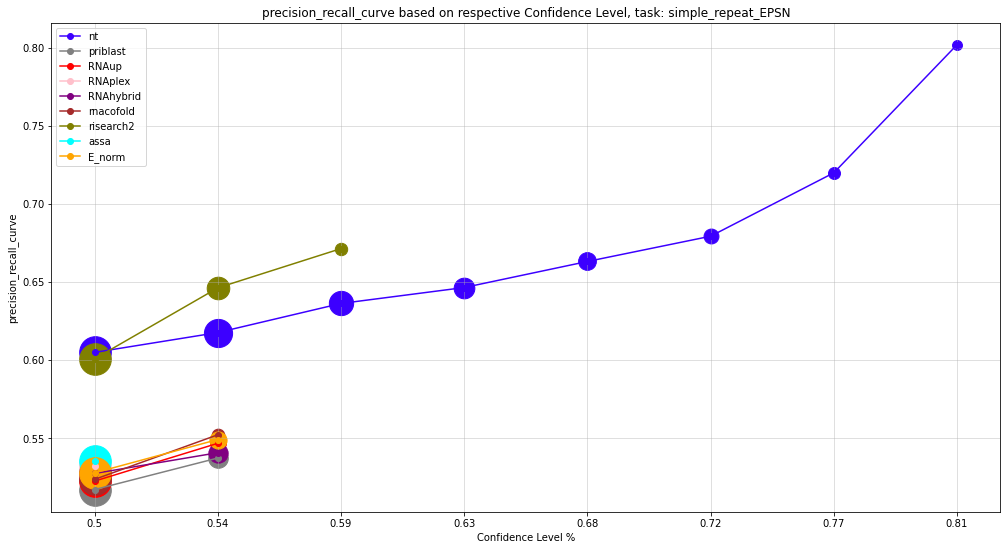

---------- DATASET: paris ----------
           -- -- -- no_simple_repeat_EPSN -- -- -- 
           -  -  -  precision_recall_curve  -  -  - 


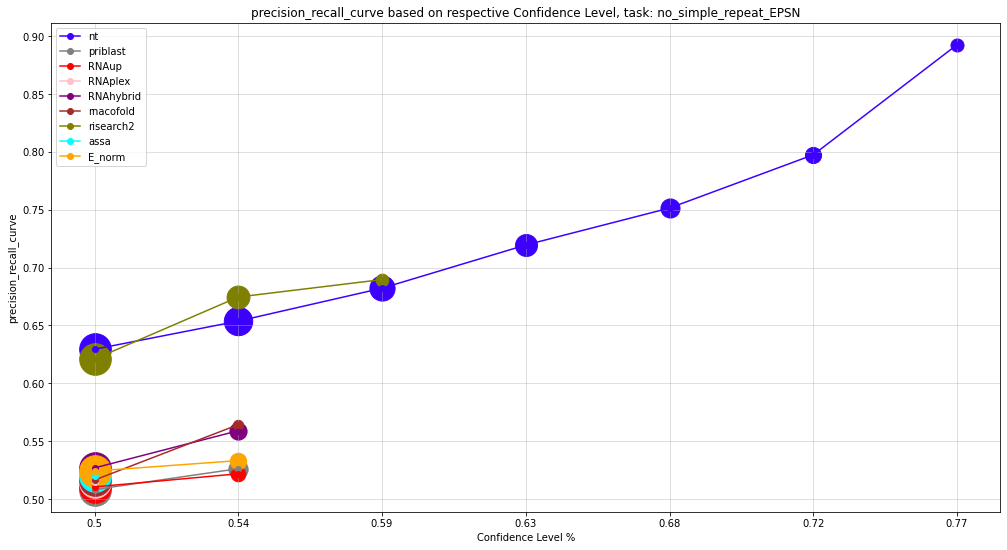

In [27]:
figsize = (17,9)
MIN_PERC = 1
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
size_multiplier = 10
n_run_undersampling = 15
list_of_metrics = ['recall', 'precision_recall_curve']
plot_function = plot_results_based_on_treshold_for_all_models
balance_at_each_step = True

for metric in list_of_metrics:
    
    for task in ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']:

        print(f'---------- DATASET: {dataset} ----------')
        print(f'           -- -- -- {task} -- -- -- ')
        print(f'           -  -  -  {metric}  -  -  - ')

        if task == 'simple_repeat_EPSN':
            assert len(sr.ground_truth.value_counts().index) == 2
            subset_to_plot = balance_df(sr).reset_index(drop = True)
        elif task == 'no_simple_repeat_EPSN':
            assert len(no_sr.ground_truth.value_counts().index) == 2
            subset_to_plot = balance_df(no_sr).reset_index(drop = True)

        plt.figure(figsize=figsize)
        plot_function(subset_to_plot, MIN_PERC = MIN_PERC, 
                      list_of_models_to_test = list_of_models_to_test, 
                      n_values = n_values, n_run_undersampling = n_run_undersampling, 
                      metric = metric, task_name = task, 
                      size_multiplier = size_multiplier, balance_at_each_step = balance_at_each_step
                     )
        plt.show()

# Riprendi da qui

f'Percentage of SR in positive predictions based on model Confidence Levels' (questo prende in considerazione tutti i positivi, e vediamo se all aumentare del livello di confidenza predilige le repeats)

In [18]:
%load_ext autoreload
%autoreload 2
from util.plot_utils import plot_results_how_many_repeats_in_pred_pos_for_all_models

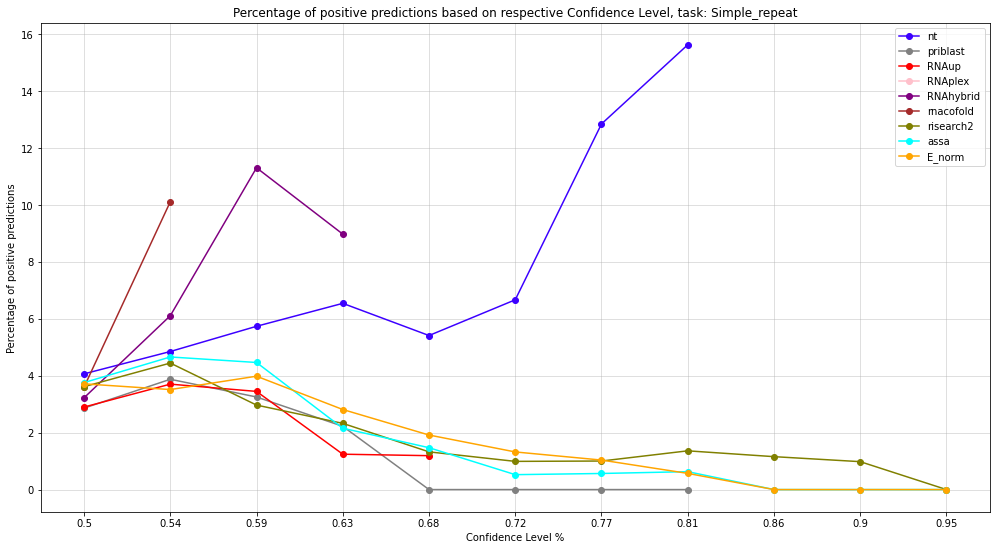

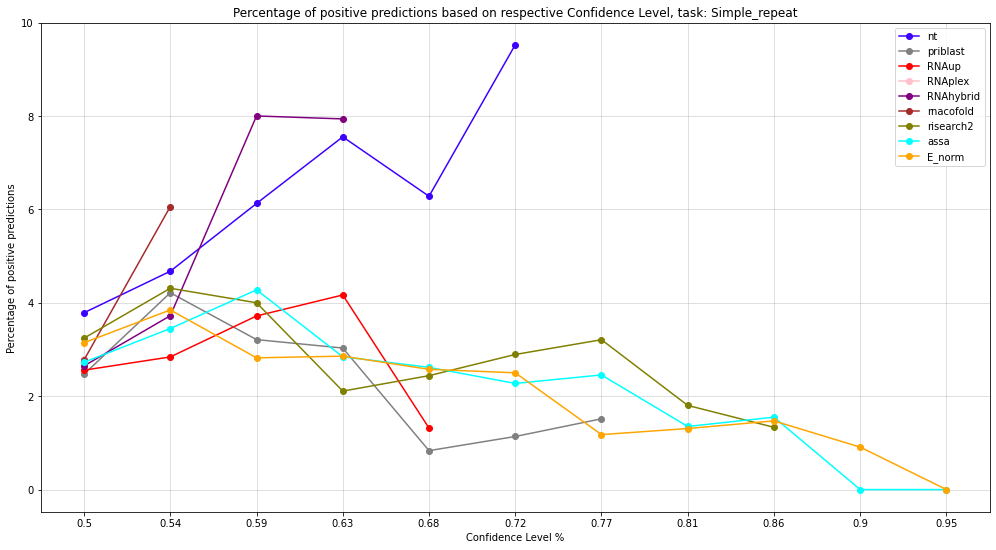

In [27]:
both_sr = True
feature_to_search = 'Simple_repeat'
MIN_PERC = 1
plt.figure(figsize=figsize)
plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True),
                                                         MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr, feature_to_search = feature_to_search
                                                        )
plt.figure(figsize=figsize)
plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True),
                                                         MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr, feature_to_search = feature_to_search
                                                        ) #these are errors

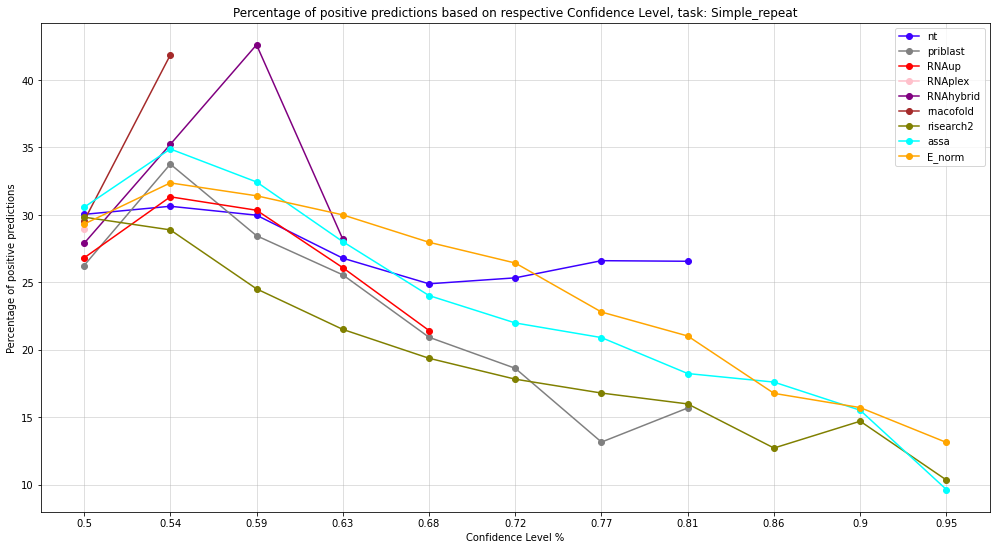

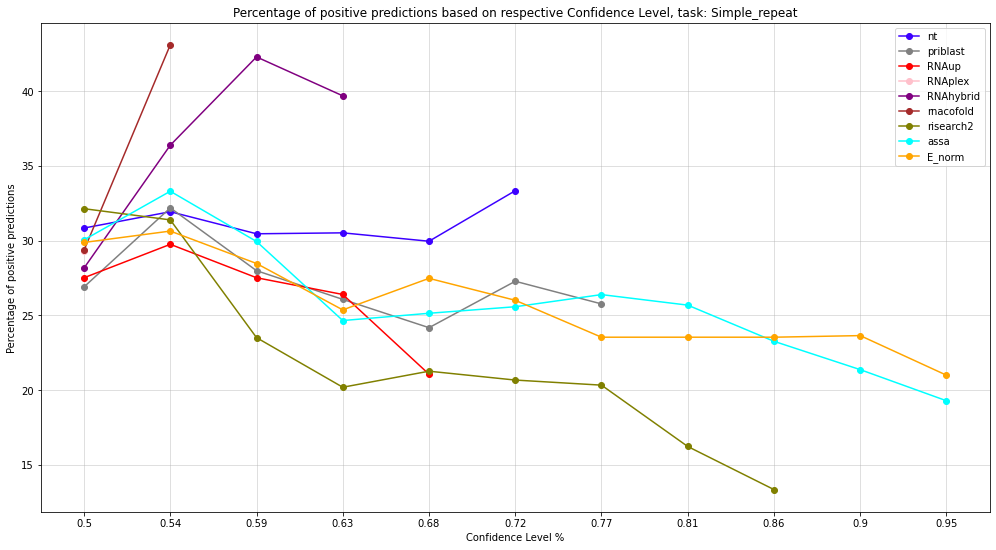

In [28]:
both_sr = False
feature_to_search = 'Simple_repeat'
MIN_PERC = 1
plt.figure(figsize=figsize)
plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'easypos'].reset_index(drop = True), 
                                                         MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr, feature_to_search = feature_to_search
                                                        )
plt.figure(figsize=figsize)
plot_results_how_many_repeats_in_pred_pos_for_all_models(res[res.policy == 'smartneg'].reset_index(drop = True), 
                                                         MIN_PERC, list_of_models_to_test, n_values = n_values, both_sr = both_sr, feature_to_search = feature_to_search
                                                        )

# TODO

Aggiungi:

- TNR rispetto alla distanza della regione di interazione nei negativi in patches500 e in patches.
- AUC based on the interaction length window treshold (non so se e meglio farlo solo rispetto alla precision. Forse no perche in realta anche gli smartneg hanno una regione di interazione piu grande). 
- Filtrare i risultati di Paris solo per le coppie HQ, ovvero quelle con positivi che hanno regione di interazione maggiore.
- Risultati di ricseq con 2 reads
- Controlla ceh i risultati di nt, intarna siano uguali tra questo script e plot_results500
- Mouse Paris
- Simple Repeats per altri dataset


Devo verificare la dipendenza dei risultati in basse alle lunghezze? (prime analisi dello script plot_results500)

Rendi le confidenze dei modelli piu alte, bisognerebbe avere un modello con slope maggiori (rank percentile)

NEL NOTEBOOK COMPARE_MODELS MI SONO CHIESTO: COME MAI IN MOLTI MODELLI (PRIMA DI OK_SN TRAINING) ALL AUMENTARE DELLA CONFIDENZA SCENDE LA PRECISIONRECALLCURVE DI SPLASH NELLE PATCHES? VERIFICA CHE QUESTA COSA SIA VERA PER QUEI MODELLI, TIPO all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0061parisHQSPLASHval0098 NEL NOTEBOOK plot_mario-ricseq_results500-RANDOM.ipynb POI VEDI SE E ANCORA VERA DOPO IL TRAINING OK_SN. E CERCA SOPRATTUTTO DI CAPIRE COME MAI. 

In [13]:
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, 'test', how, only_test, exclude_train_genes, exclude_paris_genes, exclude_paris_couples, filter_hq_ricseq, MIN_N_READS_RICSEQ, SPECIE_PARIS)
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
easypos_smartneg = balance_df(easypos_smartneg)


ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
ephnen = balance_df(ephnen)

# excluded couples:  56


In [14]:
def evaluate_threshold(df, model_column, threshold):
    mapped_signal = map_signal_to_sigmoid_range(df[model_column], threshold)
    mapped_signal = 1 - mapped_signal  # Invert for interpretation
    accuracy_gt_1 = ((mapped_signal < 0.5) & (df['ground_truth'] == 0)).mean()
    accuracy_lt_0 = ((mapped_signal >= 0.5) & (df['ground_truth'] == 1)).mean()
    total_accuracy = (accuracy_gt_1 + accuracy_lt_0) / 2  # Average accuracy
    return total_accuracy

In [15]:
df_s = easypos_smartneg.copy() 
#df_s = ephnen.copy()  

energy_columns = ['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa', 'E_norm']

best_thresholds = {}
for model_column in tqdm(energy_columns):
    best_accuracy = -1
    best_threshold = None
    min_treshold = df_s[model_column].mean() - (2 * df_s['assa'].std())
    max_treshold = df_s[model_column].mean() + (2 * df_s['assa'].std())
    max_treshold = min(0, max_treshold)
    # Define the range of potential threshold values
    potential_thresholds = np.linspace(min_treshold, max_treshold, 1_000)
    
    for threshold in potential_thresholds:
        accuracy = evaluate_threshold(df_s, model_column, threshold)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    best_thresholds[model_column] = best_threshold

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
def custom_sigmoid(x, slope_at_origin=2):
    return 0.5 + 0.5 * np.tanh(x * slope_at_origin)

def map_signal_to_sigmoid_range(signal, threshold, slope_at_origin = 2):
    mapped_signal = custom_sigmoid((signal - threshold), slope_at_origin = slope_at_origin)
    return mapped_signal

def plot_histogram_01(data, bins = 50):

    # Plot histogram
    n, bins, patches = plt.hist(data, density=True, bins=bins, alpha=0)  # Plot without displaying

    # Get the maximum value in the histogram
    max_density = max(n)

    # Scale the y-values
    n_scaled = [val / max_density for val in n]

    # Plot the scaled histogram
    plt.bar(bins[:-1], n_scaled, width=bins[1]-bins[0], color = 'orange')


In [108]:
logistic_regression_models

{'priblast': {'intercept': -1.3729273603119811,
  'coef': -0.13055111465860883,
  'threshold_value': -10.52},
 'RNAup': {'intercept': -2.341296324685742,
  'coef': -0.21942916759378597,
  'threshold_value': -10.67},
 'RNAplex': {'intercept': -0.24903541088269093,
  'coef': -0.006645756105272504,
  'threshold_value': -37.47},
 'RNAhybrid': {'intercept': -0.75438522457696,
  'coef': -0.0031159363588686754,
  'threshold_value': -242.11},
 'rnacofold': {'intercept': -0.6501092692929774,
  'coef': -0.0018752864445753833,
  'threshold_value': -346.67},
 'risearch2': {'intercept': -1.7936333925752106,
  'coef': -0.04051979821861928,
  'threshold_value': -44.27},
 'assa': {'intercept': -0.775193436517752,
  'coef': -0.07405544876174112,
  'threshold_value': -10.47},
 'E_norm': {'intercept': -1.716455777935475,
  'coef': -1.2058447675680437,
  'threshold_value': -1.42}}

In [18]:
best_thresholds

{'priblast': -10.663736035234816,
 'RNAup': -11.763679926847502,
 'RNAplex': -50.284463224637825,
 'RNAhybrid': -218.89743005947864,
 'rnacofold': -328.28183975767047,
 'risearch2': -46.44063492593665,
 'assa': -14.423598985990882,
 'E_norm': -1.301451154072943}

In [19]:
slope_at_the_origins = {
    'priblast':0.1,
    'RNAup':0.5, 
    'RNAplex':0.1, 
    'RNAhybrid':0.03,
    'rnacofold':0.02,
    'risearch2':0.1, 
    'assa':0.2,
    'E_norm':2,
}

------- priblast -------


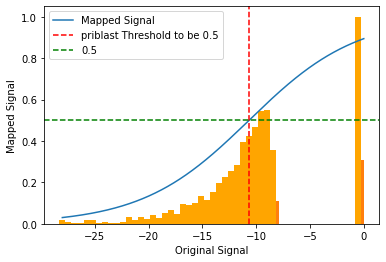

------- RNAup -------


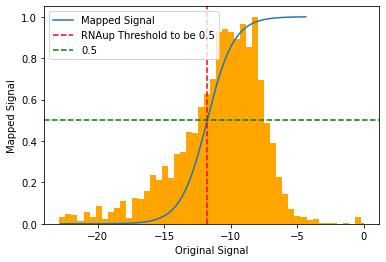

------- RNAplex -------


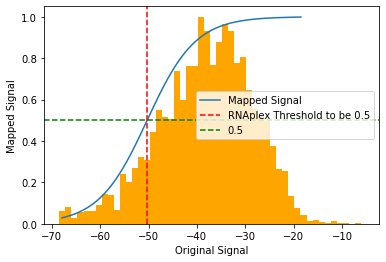

------- RNAhybrid -------


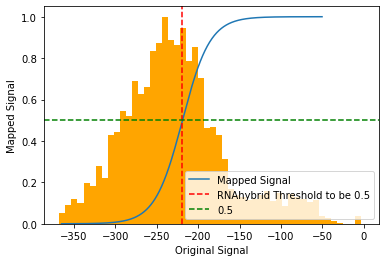

------- rnacofold -------


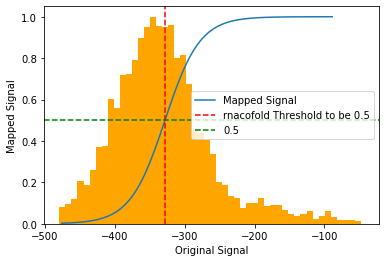

------- risearch2 -------


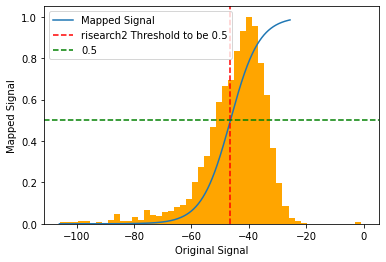

------- assa -------


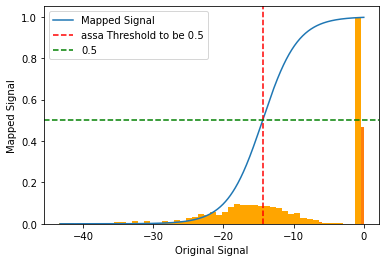

------- E_norm -------


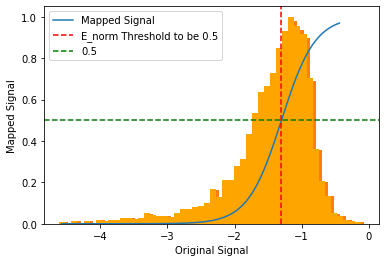

In [20]:
for tool_name in energy_columns:

    print(f'------- {tool_name} -------')
    treshold =  best_thresholds[tool_name]
    min_value_to_plot = res[tool_name].quantile(0.01)
    max_value_to_plot = res[tool_name].quantile(0.99)
    slope_at_origin = slope_at_the_origins[tool_name]

    # Example usage
    signal_range = np.linspace(min_value_to_plot, max_value_to_plot, 1000)


    mapped_signal = map_signal_to_sigmoid_range(signal_range,treshold, slope_at_origin = slope_at_origin)

    data_balanced = balance_df(res)
    data_balanced = data_balanced[data_balanced[tool_name]>min_value_to_plot].reset_index(drop = True)


    # Plotting the results
    plt.plot(signal_range, mapped_signal, label='Mapped Signal')
    plot_histogram_01(data_balanced[tool_name])

    #plt.hist(data_balanced[tool_name], density=True, bins=80) 
    plt.axvline(x=treshold, color='r', linestyle='--', label=f'{tool_name} Threshold to be 0.5')
    plt.axhline(y=0.5, color='g', linestyle='--', label='0.5')
    plt.xlabel('Original Signal')
    plt.ylabel('Mapped Signal')
    plt.legend()
    plt.show()